# **PROJET RAKUTEN**

<center><img src="https://assets-datascientest.s3-eu-west-1.amazonaws.com/train/logo_datascientest.png" style="height:150px;center"></center>

# **Tables des matières**
<hr style="border-width:2px;border-color:#75DFC1">

>🚀[Les imports](#imports)

>🚀 [Fonctions globales](#functions)

>🚀 [Chargement des données du PICKLE](#load)

>🚀 [Dataset cible](#cible)

>🚀 [X_text & target](#x_target)

>🚀 [SPLIT : X_train, X_test, y_train, y_test](#split)

>🚀 [MODELISATION TEXTE](#text_models)

>🚀 [LSTM avec GLOVE](#lstm1)

>🚀 [Modèles sans set pre-entraîné](#text_others)

>🚀 [Model1 : conv1D](#conv1)

>🚀 [Model1.1 Conv1D](#conv1.1)

>🚀 [Modèle2 : LSTM](#lstm2)
<hr style="border-width:2px;border-color:#75DFC1">


## <a name="imports"> 🚀A1 All imports and constants</a> 

In [2]:
# All imports
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
## callback
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback
from keras.callbacks import CSVLogger
from tensorflow.keras.layers import (Input, Dense, Activation, Conv2D, MaxPooling2D, GlobalMaxPool1D,
                                     GlobalAveragePooling1D, GlobalAveragePooling2D, 
                                     Dropout, Flatten, LSTM, Embedding, SpatialDropout1D,Conv1D, 
                                     MaxPooling1D, GRU, BatchNormalization, RNN)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import imagenet_utils


from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from keras.models import save_model

#from scikeras.wrappers import KerasClassifier

import itertools
import os
import shutil
import random
import datetime


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os 
import glob 

import pandas as pd
import numpy as np 

import re

from PIL import Image 
import cv2

# gensim lib
from gensim.models import word2vec
from gensim.test.utils import get_tmpfile, common_texts
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import Word2Vec
from gensim.utils import tokenize

# resampling
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.utils import shuffle

from sklearn.metrics import roc_auc_score

    
# define constants
data_root_folder = "../data"
data_images_root_folder = "../data/images"


# defaut matplotlib resources (font)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 14  

## <a name ="functions"> 🚀A2 Commmon helper functions</a>

In [3]:


def get_df_basic_elements(df, infos_types= ['shape', 'head', 'tail', 'info', 'describe'], actions= ['return', 'print']):
    ret = {}
    if isinstance(df, pd.DataFrame):
        if 'shape' in infos_types:
            df_shape = df.shape
            if 'print' in  actions: 
                print("shape------------------------------------------------------")
                print(df_shape)
            if 'return' in actions:
                ret['shape'] = str(df_shape)
        if 'head' in infos_types:
            df_head = df.head()
            if 'print' in  actions: 
                print("head------------------------------------------------------")
                display(df_head)
            if 'return' in actions:
                ret['head'] = str(df_head)
        if 'tail' in infos_types:
            df_tail = df.tail()
            if 'print' in  actions: 
                print("tail------------------------------------------------------")
                display(df_tail)
            if 'return' in actions:
                ret['tail'] = str(df_tail)
        if 'info' in infos_types:
            df_info = df.info()
            if 'print' in  actions: 
                print("info------------------------------------------------------")
                display(df_info)
            if 'return' in actions:
                ret['info'] = str(df_info)
        if 'describe' in infos_types:
            df_describe = df.describe()
            if 'print' in  actions: 
                print("describe------------------------------------------------------")
                display(df_describe)
            if 'return' in actions:
                ret['describe'] = str(df_describe)
        
        if 'return' in actions:
            return {'data': ret}
    return {'data': ret}              
                

def isFileExist(fileFullPath):
    if fileFullPath is not None:
        if os.path.isfile(fileFullPath):
            if os.path.exists(fileFullPath):
                return True
            else:
                return False
        else:
            return False
    else:
        return False


def get_cat_codes_description(cat_codes_file):
    return pd.read_csv(f'{data_root_folder}/config/{cat_codes_file}', sep=';', quotechar="'", index_col=0)
    

def get_prod_cateroy_description_from_code(prod_code):
    """Récupérer la catégorie descrptive à partir de son code numérique par mappage

    Args:
        code (int): code numérique de la catégorie de produit
    """

    ret_code = 0
    ret_df = get_cat_codes_description('category_code_desription.csv')
  
    #if isinstance(prod_code, int):
    ret_code = ret_df.loc[prod_code, 'prdtypelabelguess']
    return ret_code


def get_conf_matrix(y_true, y_pred, classes, title):
    cnf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
    display(pd.DataFrame(cnf_matrix))

    h = len(classes)*1.5
    w = h + 2
    plt.figure(figsize=(w,h))

    plt.imshow(cnf_matrix, interpolation='nearest',cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right', fontsize=24)
    plt.yticks(tick_marks, classes, fontsize=24)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                horizontalalignment="center",
                color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black", fontsize=24)

    plt.ylabel('Classes réelles', fontsize=24)
    plt.xlabel('Classes prédites', fontsize=24)
    plt.show()


def plot_history(history, cols={'acc': 'acc', 'val_acc': 'val_acc', 'loss': 'loss', 'val_loss': 'val_loss'}, title=''):
    if hasattr(history, 'history'):
        acc = history.history[cols['acc']]
        val_acc = history.history[cols['val_acc']]
        loss = history.history[cols['loss']]
        val_loss = history.history[cols['val_loss']]
    elif hasattr(history, 'history_'):
        acc = history.history_[cols['acc']]
        val_acc = history.history_[cols['val_acc']]
        loss = history.history_[cols['loss']]
        val_loss = history.history_[cols['val_loss']]
    else:
        return
        
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy' + title)
    plt.legend()
    plt.xlabel('EPOCH')
    plt.ylabel('ACCURACY')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss' + title)
    plt.xlabel('EPOCH')
    plt.ylabel('LOSS')
    plt.grid(True)
    plt.legend()


def define_X_target(dataframe=pd.DataFrame(None), columns_to_drop_from_X=[], target_columns=[]):
    if isinstance( dataframe, pd.DataFrame):
        X = dataframe.drop(columns_to_drop_from_X, axis = 1)
        target = dataframe[target_columns]
    return pd.DataFrame(X), pd.DataFrame(target) 
        

def get_train_test_split(X, y, test_size=.2, random_state=0, scale=False, scaler=preprocessing.StandardScaler()):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    try:
        if scale == True:
            # apply the scaler to X_train by transform method to get X_train_scaled
            X_train = pd.DataFrame( scaler.fit_transform(X_train), columns=X_train.columns )
            X_test = pd.DataFrame( scaler.fit_transform(X_test), columns=X_test.columns )

        return  X_train, X_test, y_train, y_test 
    except:
        print(f"Exception rencontrée. vérifier que les données sont scalables (scale={scale})")
        return None, None, None, None  

    
def get_predictions(model, x_test, save_to_csv=False, csv_file_name="model.csv"):
    # prédire la catégorie avec la probabilité de chaque classe
    y_pred = model.predict(x_test)
    print("y_pred=", y_pred)
    #u_pred = pd.DataFrame(y_pred)
    #u_pred = np.round(y_pred*100, 5)
    y_pred_df = pd.DataFrame(y_pred)
    if save_to_csv==True:
        y_pred_df.to_csv(f'{data_root_folder}/models/model_text.csv', index = False)
    return y_pred_df
    print(y_pred_df.shape)
    display(y_pred_df.head())
    
    
def get_classif_report(model, X_test, y_test):
    y_pred=np.argmax(model.predict(X_test), axis=-1)
    classif_report = pd.DataFrame(classification_report_imbalanced(y_test, y_pred, output_dict = True)).transpose()
    return classif_report

def evaluate_model(model, X_test, y_test, batch_size=100):
    valid_score = model.evaluate(X_test, y_test, batch_size=batch_size)
    # return accuracy (in %) and loss values
    return valid_score[1]*100, valid_score[0]
    

def get_roc_score(y_test, probas_pred):  
    auc_roc = roc_auc_score(y_true=y_test, y_score=probas_pred)
    return auc_roc



## <a name="load"> 🚀B1 Load data from PICKLE</a>

In [4]:
print("Reading from pickle file " + f"{data_root_folder}/cleaned_data.pkl ...")
df = pd.read_pickle(f"{data_root_folder}/cleaned_data.pkl")

# ajouter la colone nom_image indiquant le nom du fichier image
df['imageid']= df['imageid']
df['prdtypecode']= df['prdtypecode']
df['nom_image'] = "image" + "_" + df['imageid'].astype('str') + "_product_" + df['prdtypecode'].astype('str') + ".jpg"

# ajouter une colonne d'encodage des codes produits 'prdtypecode_encoded'
unique_prod_codes = np.sort(df['prdtypecode'].unique())
#print(unique_prod_codes)
#print(unique_prod_codes.argsort(axis=0).argsort())
df['prdtypecode_encoded'] =  df['prdtypecode'].apply(lambda x: np.where(unique_prod_codes==x)[0][0])

print(type(df))
print(df.shape)
print(df.info())
display(df)

Reading from pickle file ../data/cleaned_data.pkl ...
<class 'pandas.core.frame.DataFrame'>
(82265, 8)
<class 'pandas.core.frame.DataFrame'>
Index: 82265 entries, 0 to 84915
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   designation          82265 non-null  object
 1   description          82265 non-null  object
 2   productid            82265 non-null  int64 
 3   imageid              82265 non-null  int64 
 4   prdtypecode          82265 non-null  int64 
 5   desi_desc            82265 non-null  object
 6   nom_image            82265 non-null  object
 7   prdtypecode_encoded  82265 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 5.6+ MB
None


designation  \
0      Olivia: Personalisiertes Notizbuch / 150 Seite...   
1      Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
2      Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
3      Peluche Donald - Europe - Disneyland 2000 (Mar...   
4                                   La Guerre Des Tuques   
...                                                  ...   
84911                        The Sims [ Import Anglais ]   
84912  Kit piscine acier NEVADA déco pierre Ø 3.50m x...   
84913  Journal Officiel De La Republique Francaise N°...   
84914  Table Basse Bois De Récupération Massif Base B...   
84915  Gomme De Collection 2 Gommes Pinguin Glace Ver...   

                                             description   productid  \
0                                                         3804725264   
1                                                          436067568   
2      PILOT STYLE Touch Pen de marque Speedlink est ...   201115110   
3                                                           50418756   
4      Luc a des id&eacute;es de grandeur. Il veut or...   278535884   
...                                                  ...         ...   
84911                                                      206719094   
84912                                                     3065095706   
84913                                                      440707564   
84914  <p>Cette table basse a un design unique et con...  3942400296   
84915                                                       57203227   

          imageid  prdtypecode  \
0      1263597046           10   
1      1008141237         2280   
2       938777978           50   
3       457047496         1280   
4      1077757786         2705   
...           ...          ...   
84911   941495734           40   
84912  1188462883         2583   
84913  1009325617         2280   
84914  1267353403         1560   
84915   684671297         2522   

                                               desi_desc  \
0      olivia personalisiertes notizbuch seiten punkt...   
1      journal arts art marche salon art asiatique ba...   
2      stylet ergonomique gamepad nintendo wii speedl...   
3      peluche donald europe disneyland marionnette d...   
4      guerre tuques luc ideacute grandeur veut organ...   
...                                                  ...   
84911                                           the sims   
84912               kit piscine acier nevada déco pierre   
84913  journal officiel republique changement adresse...   
84914  table basse bois récupération massif base blan...   
84915                  gomme gommes pinguin glace orange   

                               nom_image  prdtypecode_encoded  
0        image_1263597046_product_10.jpg                    0  
1      image_1008141237_product_2280.jpg                   18  
2         image_938777978_product_50.jpg                    2  
3       image_457047496_product_1280.jpg                    7  
4      image_1077757786_product_2705.jpg                   25  
...                                  ...                  ...  
84911     image_941495734_product_40.jpg                    1  
84912  image_1188462883_product_2583.jpg                   23  
84913  image_1009325617_product_2280.jpg                   18  
84914  image_1267353403_product_1560.jpg                   13  
84915   image_684671297_product_2522.jpg                   21  

[82265 rows x 8 columns]

## <a name="cible"> 🚀B2 Définition du dataset cible **image et texte**</a>

In [5]:
## sélectionner uniquement les variables sur lesquelles les modèles travailleront
df_cible = df[['desi_desc', 'nom_image', 'prdtypecode', 'prdtypecode_encoded']] 
df_cible.shape
## mélanger le dataframe
#seed = 1245
#df_cible= shuffle(df_cible, random_state = 1234) 
#df_cible

(82265, 4)

## <a name="x_target">🚀B3 Définir X_text & target</a> 

In [6]:
load_from_pickle = False
X_target_file = 'X_text_target.pkl'

#-------------------------------------------------------------------------------------------------------
# pourcentage retenu du dataset pour réduire sa taille à des fins de tests en garatissant la présence de toutes les 27 classes et l'équilibrage 
PURC_DF_LINES = 100  # % du dataset à inclure dans le modème train+test
MAX_DF_LINES = int(round(df_cible.shape[0] * (PURC_DF_LINES/100), 0))
print("MAX_DF_LINES=", MAX_DF_LINES, "sur", df_cible.shape[0])
#-------------------------------------------------------------------------------------------------------

if load_from_pickle == False:
    print("Defininin X_text, target...")
    X_text, target = define_X_target(df_cible, ['prdtypecode_encoded', 'nom_image', 'prdtypecode'], 'prdtypecode_encoded')
    # supprimer les colonnes 'designation et 'description' qui ne seront pas utilisées
    #X = X.drop(['designation', 'description'], axis=1)
    print(f'writting X_text and target to pickle file {data_root_folder}/{X_target_file}')
    #pd.to_pickle((X_text, target), f'{data_root_folder}/{X_target_file}')
else:
    if (isFileExist(f"{data_root_folder}/{X_target_file}")):
        print(f"Load data from pickle file {f'{data_root_folder}/{X_target_file}'}...")
        X_text, target = pd.read_pickle(f'{data_root_folder}/{X_target_file}')
    else:
        print(f"Erreur de chargement du fichier f'{data_root_folder}/{X_target_file}")

if MAX_DF_LINES < df_cible.shape[0]:
    X_text, target = X_text.iloc[0:1+MAX_DF_LINES, :], target.iloc[0:1+MAX_DF_LINES, :]
        

print(X_text.info())
print(target.info())

print(type(X_text))
print(type(target))
print("X_text.shape=", X_text.shape)
print("target.shape=", target.shape)
display(X_text.head())
display(target.head())


MAX_DF_LINES= 82265 sur 82265
Defininin X_text, target...
writting X_text and target to pickle file ../data/X_text_target.pkl
<class 'pandas.core.frame.DataFrame'>
Index: 82265 entries, 0 to 84915
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   desi_desc  82265 non-null  object
dtypes: object(1)
memory usage: 1.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 82265 entries, 0 to 84915
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   prdtypecode_encoded  82265 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB
None
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
X_text.shape= (82265, 1)
target.shape= (82265, 1)


desi_desc
0  olivia personalisiertes notizbuch seiten punkt...
1  journal arts art marche salon art asiatique ba...
2  stylet ergonomique gamepad nintendo wii speedl...
3  peluche donald europe disneyland marionnette d...
4  guerre tuques luc ideacute grandeur veut organ...

prdtypecode_encoded
0                    0
1                   18
2                    2
3                    7
4                   25

## <a name="split">🚀B4 SPLIT : X_train, X_test, y_train, y_test</a> 

In [7]:
# selectionner un des scalers les plus communs en fonction des modèles : StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler or Normalizer

scale = False
# one prend que la colonne 'desi_desc' de X
X_text_train, X_text_test, y_train, y_test = get_train_test_split(X=X_text, y=target, test_size=.2, random_state=0, scale=scale, scaler=preprocessing.Normalizer())
#y_train = y_train.astype(int)
#y_test = y_test.astype(int)

print("X_train.shape=", X_text_train.shape)
print("X_test.shape=", X_text_test.shape)
print(type(X_text_train))
print(type(X_text_test))
display(X_text_train.head())
display(X_text_test.head())
display(y_train)
display(y_test)


X_train.shape= (65812, 1)
X_test.shape= (16453, 1)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


desi_desc
77033                                           you days
54209                           cassette recharge blanco
19852                           action man mission tokyo
39964  bâche bulles bordée ubbink bâche bulle piscine...
68850                                       mémoire arts

desi_desc
30891  jésus dictionnaire historique évangiles histor...
11771  haie artificielle campovert rouleau haie artif...
4178   pack spa rond gonflable silver cloud places an...
32162  drapeau table saint david xcm drapeaux bureau ...
14820                                         homme yeux

prdtypecode_encoded
77033                    0
54209                   21
19852                    4
39964                   23
68850                   18
...                    ...
21561                   23
47024                   24
43629                   25
44611                   11
70289                   25

[65812 rows x 1 columns]

prdtypecode_encoded
30891                   25
11771                   22
4178                    23
32162                   16
14820                    0
...                    ...
33719                   24
46523                   16
35962                   16
43564                    0
36286                   18

[16453 rows x 1 columns]

## <a name="text_models"> 🚀C1 **MODELISATION TEXTE**</a>

>Vérifier la répartition moyenne train vs test

In [44]:

all_text_train = ''.join(X_text_train['desi_desc'])
all_text_test = ''.join(X_text_test['desi_desc'])
mean_train = round(len(all_text_train)/X_text_train.shape[0], 0)
mean_test = round(len(all_text_test)/X_text_test.shape[0], 0)
print(f"Taille moyenne du texte de chaque ligne du dataset 'desi_desc' du train set : {mean_train} sur un tot de : {len(all_text_train)}")
print(f"Taille moyenne du texte de chaque ligne du dataset 'desi_desc' du test set : {mean_test} ur un tot de : {len(all_text_test)}")
if mean_train>mean_test:
    print(f"Le train set contient plus de mots globalement que le test set dans la proportion de : {100*round(mean_train/mean_test,2)}%")
elif mean_train<mean_test:
    print(f"Le test set contient plus de mots globalement que le train set dans la proportion de : {100*round(mean_test/mean_train,2)}%")
else:
    print("Les deux set sont équilibrés en taille totale !")
    

Taille moyenne du texte de chaque ligne du dataset 'desi_desc' du train set : 282.0 sur un tot de : 9272673

Taille moyenne du texte de chaque ligne du dataset 'desi_desc' du test set : 283.0 ur un tot de : 2328264

Le test set contient plus de mots globalement que le train set dans la proportion de : 100.0%


>Common **fit Callbacks**

In [8]:
#---------- add callbacks---------------
## changer le taux d'apprentissage en fonction de la perte
lr_plateau = ReduceLROnPlateau(monitor='val_loss',
                                         patience=5, #si val_loss stagne sur 3 epochs consécutives selon la valeur min_delta
                                         min_delta= 0.001,
                                         factor=0.01,  # On réduit le learning rate d'un facteur 0.01
                                         cooldown =5, # On attend 5 epochs avant de réitérer 
                                         verbose=1,
                                         mode='min')

## arrêter l'apprentissage
early_stopping = EarlyStopping(monitor='val_loss',
                                         patience= 5, # Attendre 5 epochs avant application
                                         min_delta = .0005, # écart min (voir mode)
                                         verbose = 1, # Afficher à quel epoch on s'arrête
                                         mode='min',
                                         restore_best_weights=True)


## enregistrer le modèle
d = datetime.datetime.now
checkpoint = ModelCheckpoint(filepath=f"{data_root_folder}/checkpoint/checkpoint{d}.keras", 
                                       monitor='val_loss',
                                       save_best_only=False,
                                       save_weights_only=False,
                                       mode='min',
                                       save_freq='epoch')

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = datetime.datetime.now()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(datetime.datetime.now()-self.starttime)

# instantier le callback timer
time_callback = TimingCallback()


csv_logger = CSVLogger(f"{data_root_folder}/csv_files/models_fits.csv", separator=",", append= True)
callbacks = [lr_plateau, early_stopping, time_callback]


>Global CONSTANTS and variable

In [9]:
EMBEDDING_DIM = 200 # 200-dimensional vector
MAX_SEQUENCE_LENGTH = 500 # max length of each entry (sentence), including padding 
## hyperparamètres texte
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
max_sentence_len = MAX_SEQUENCE_LENGTH

# variable des classes à utiliser dans les modèles
n_classes = len(unique_prod_codes)

### <a name="lstm1"> 🚀C1.1 **GLOVE (Global Vectors for Word Representation)** comme set pre-entraîné</a>

>Voir: https://medium.com/@mervebdurna/advanced-word-embeddings-word2vec-glove-and-fasttext-26e546ffedbd

    A partir d'ici, on peut appliquer directement le modèle ci-dessous ou effectuer un **GridSearchCV** plus bas

>Définir le modèle avec embedding de **GLOVE**

>1. load_glove_vectors

In [36]:
import csv
def load_model_elements():
    
    # vectoriser le dict à partir de glove.6B.100d (Global Vectors for Word Representation)
    start_1 = datetime.datetime.now()
    print("Step 1 : Charger les vecteurs GLOVE...")
    glove_file = (f'{data_root_folder}/glove/glove.6B.{EMBEDDING_DIM}d.txt')
    tmp_file = get_tmpfile("test_word2vec.txt")

    _ = glove2word2vec(glove_file, tmp_file)

    glove_vectors = KeyedVectors.load_word2vec_format(tmp_file)
    duration = datetime.datetime.now() - start_1
    print("Durée :", duration.total_seconds())
    
    
    # Tokeniser la colonne texte 'desi_desc'
    start_2 = datetime.datetime.now()
    print("Step 2 : Tokenization...")
    from nltk.tokenize import word_tokenize as WordTokenizer
    def word_tokenizer(data):
        tokens=[]
        for item in data:
            tokens.append(WordTokenizer(item))
        return tokens

    #token = word_tokenizer(text)
    tokens = word_tokenizer(df_cible['desi_desc'])
    
    # moyenne des phrases 250 (MAX_SEQUENCE_LENGTH)
    base_model = Word2Vec(vector_size=MAX_SEQUENCE_LENGTH, min_count=1, window=5, epochs=100)
    base_model.build_vocab(tokens)
    total_examples = base_model.corpus_count
    duration = datetime.datetime.now() - start_2
    print("Durée :", duration.total_seconds())

    
    print("Step 3 : Construction de la matrice des poids w2v_weights, de vocab_size et embedding_size ...")
    start_3 = datetime.datetime.now()
    # add GloVe's vocabulary & weights
    base_model.build_vocab([list(glove_vectors.key_to_index.keys())], update=True)
    # train on your data
    base_model.train(tokens, total_examples=total_examples, epochs=base_model.epochs)
    base_model_wv = base_model.wv
    
    w2v_weights = base_model_wv.vectors
    vocab_size, embedding_size = w2v_weights.shape
    print(f"vocab_size, embedding_size = {vocab_size}, {embedding_size}")
    
    pretrained_weights = base_model_wv.vectors
    vocab_size, emdedding_size = pretrained_weights.shape
    print(f"vocab_size, embedding_size = {vocab_size}, {embedding_size}")
    
    ## dictionnaire (word ==> Index)
    word2idx =  base_model_wv.key_to_index 

    ## enregistrer les nouveaux embeddings (à voir l'utilité ?)
    base_model_wv.save(f'{data_root_folder}/embedding/embeddings.txt')
    #GLOVE_DIR = "glove.6B."+str(EMBEDDING_DIM)+"d.txt"
    duration = datetime.datetime.now() - start_3
    print("Durée :", duration.total_seconds())
    
    
    print("Step 4 : Génération des matrices train_x & val_x ...")
    start_4 = datetime.datetime.now()
    #--------------------Définir training set **train_text**
    # créer des séquences 250 = max_sentence_len mots max et les indexer
    train_text_samples_tot = X_text_train['desi_desc']
    sentences = [[word for word in document.lower().split()[:max_sentence_len]] for document in train_text_samples_tot]
    # initialiser par des 0
    train_x = np.zeros([len(sentences), max_sentence_len], dtype=np.int32)

    # transformer en matrice
    for i,sentence in enumerate(sentences):
        for t, word in enumerate(sentence): 
            if word2idx.get(word) is not None:
                train_x[i, t] = word2idx.get(word)
    
    #--------------------Définir test set **test_text**            
    val_text_samples_tot = X_text_test['desi_desc']
    sentences_val = [[word for word in document.lower().split()[:max_sentence_len]] for document in val_text_samples_tot]

    val_x = np.zeros([len(sentences_val), (max_sentence_len)], dtype=np.int32)

    for i,sentence in enumerate(sentences_val):
        for t, word in enumerate(sentence): 
            if word2idx.get(word) is not None:
                val_x[i, t] = word2idx.get(word)
    duration = datetime.datetime.now() - start_4
    print("Durée :", duration.total_seconds())
                
    return base_model_wv, w2v_weights, vocab_size, embedding_size, train_x, val_x 
    
    
base_model_wv, w2v_weights, vocab_size, embedding_size, train_x, val_x = load_model_elements()
    

Step 1 : Charger les vecteurs GLOVE...


C:\Users\abdel\AppData\Local\Temp\ipykernel_7028\556403150.py:10: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  _ = glove2word2vec(glove_file, tmp_file)


Durée : 130.291711
Step 2 : Tokenization...
Durée : 13.981484
Step 3 : Construction de la matrice des poids w2v_weights, de vocab_size et embedding_size ...
vocab_size, embedding_size = 511034, 500
vocab_size, embedding_size = 511034, 500
Durée : 538.98085
Step 4 : Génération des matrices train_x & val_x ...
Durée : 1.609097


> Pour tester uniquement

In [13]:
## vérification de la bonne compilation
#print('Result embedding shape:', pretrained_weights.shape)
print('Checking similar words:')
for word in ['couette', 'table', 'immobilier', 'piscine', 'jeu', 'chaise', 'poupée', 'figurine', 'console', 'chaussures']:
  most_similar = ', '.join('%s (%.2f)' % (similar, dist) 
                           for similar, dist in base_model_wv.most_similar(word)[:8])
  print('  %s ==> %s' % (word, most_similar))

# get index corresponding to a word
def word2idx(word):
  return base_model_wv.key_to_index[word]

# get the word corresonding to an index
def idx2word(idx):
  return base_model_wv.index2word[idx]

Checking similar words:
  couette ==> neet (0.41), inquiètez (0.39), ransta (0.39), gräce (0.38), filscm² (0.38), parure (0.37), cadum (0.37), moakoada®alliage (0.37)
  table ==> tables (0.45), jabron (0.36), bevons (0.35), hélicoïde (0.34), châtelaine (0.33), strobepackage (0.33), baroque (0.32), vallee (0.31)
  immobilier ==> reussite (0.76), honoraires (0.66), viiconseils (0.62), ivles (0.58), sollicite (0.58), lithiumweight (0.58), lineuse (0.57), schnock (0.54)
  piscine ==> piscines (0.59), eau (0.49), bâche (0.48), bassin (0.47), filtration (0.44), litres (0.43), horssol (0.40), pompe (0.39)
  jeu ==> jeux (0.46), joueurs (0.38), guérissez (0.37), enfants (0.36), incarnez (0.36), quiz (0.36), petis (0.36), minijeux (0.36)
  chaise ==> chaises (0.44), fauteuil (0.38), tabouret (0.36), cuscino (0.36), accoudoirs (0.36), assise (0.36), transat (0.36), pouf (0.35)
  poupée ==> poupées (0.45), doll (0.44), xheadband (0.42), truquée (0.40), bjd (0.36), xclothes (0.35), poupee (0.35), 

>2. Define model

In [37]:

#---------- Définir le modèle---------------

def create_model_text_with_glove():
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_size,
                            #weights=[w2v_weights], # set weights after model creation
                            input_length=MAX_SEQUENCE_LENGTH,
                            mask_zero=False,
                            trainable=False)
    embedded_sequences = embedding_layer(sequence_input)
    x = LSTM(100, return_sequences=True,name='lstm_layer')(embedded_sequences)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.2)(x)
    preds = Dense(n_classes, activation="softmax")(x)

    model_text = Model(sequence_input, preds)
    
    # display model summary
    model_text.summary()
    
    # add GLOVE weight matrix after model creation NOT at layer creation (change in tensorflow 2.16 and +)
    model_text.layers[1].set_weights([w2v_weights])
    
    model_text.compile(optimizer= 'adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']
             )
     
    return model_text


model_text = create_model_text_with_glove()

# create KerasClassifier
#model_text = KerasClassifier(model=create_model_text_with_glove(), epochs = 30, batch_size=150, validation_split=.2,
#                    optimizer='adam',  callbacks = callbacks, verbose=1)

# L'optimizer Adam ne donne pas de résulats probants
#model_text_1 = KerasClassifier(model=create_model_text_with_glove(), epochs = 30, batch_size=150, validation_split=.2,
#                    optimizer=Adam(learning_rate=1e-3),  callbacks = callbacks, verbose=1)
 


#-------------------------------------------------------------------------------------------
# Un autre modèle avec moins de couches input->embedding (avec le GLOve)->Dropout->GlobalAveragePooling1D->Dropout->Dense
# Résulats NOK => abandon
#-------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------
# Un autre modèle avec moins de couches input->embedding (sans le GLOve)->Dropout->GlobalAveragePooling1D->Dropout->Dense
# /!\Résulats NOK => abandon/!\
#-------------------------------------------------------------------------------------------
def create_model_text_with_glove_1():
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_size,
                            #weights=[w2v_weights], # set weights after model creation
                            input_length=MAX_SEQUENCE_LENGTH,
                            mask_zero=False,
                            trainable=False)
    embedded_sequences = embedding_layer(sequence_input)
    x = LSTM(100, return_sequences=True, name='lstm_layer')(embedded_sequences)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.2)(x)
    preds = Dense(n_classes, activation="softmax")(x)

    model_text = Model(sequence_input, preds)
    
    # display model summary
    model_text.summary()
    
    model_text.compile(optimizer= 'adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']
             )
     
    return model_text
 
# create KerasClassifier
#model_text_2 = KerasClassifier(model=create_model_text_with_glove_1(), epochs = 15, batch_size=200, validation_split=.2,
#                    optimizer='adam',  callbacks = callbacks, verbose=1) 



d:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 500, 500)       │   255,517,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 500, 100)       │       240,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 100)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 27)             │         1,377 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 255,763,827 (975.66 MB)

 Trainable params: 246,827 (964.17 KB)

 Non-trainable params: 255,517,000 (974.72 MB)

>3. Entrainer le modèle

Training progress:
=>EPOCHS: 15 =>bach_size: 150
Epoch 1/15
384/384 ━━━━━━━━━━━━━━━━━━━━ 292s 760ms/step - accuracy: 0.7401 - loss: 0.8641 - val_accuracy: 0.7577 - val_loss: 0.7923 - learning_rate: 0.0010
Epoch 2/15
384/384 ━━━━━━━━━━━━━━━━━━━━ 282s 734ms/step - accuracy: 0.7616 - loss: 0.7814 - val_accuracy: 0.7679 - val_loss: 0.7678 - learning_rate: 0.0010
Epoch 3/15
384/384 ━━━━━━━━━━━━━━━━━━━━ 274s 713ms/step - accuracy: 0.7761 - loss: 0.7279 - val_accuracy: 0.7728 - val_loss: 0.7549 - learning_rate: 0.0010
Epoch 4/15
384/384 ━━━━━━━━━━━━━━━━━━━━ 272s 707ms/step - accuracy: 0.7888 - loss: 0.6773 - val_accuracy: 0.7734 - val_loss: 0.7459 - learning_rate: 0.0010
Epoch 5/15
384/384 ━━━━━━━━━━━━━━━━━━━━ 285s 743ms/step - accuracy: 0.8034 - loss: 0.6345 - val_accuracy: 0.7760 - val_loss: 0.7421 - learning_rate: 0.0010
Epoch 6/15
384/384 ━━━━━━━━━━━━━━━━━━━━ 316s 823ms/step - accuracy: 0.8133 - loss: 0.6015 - val_accuracy: 0.7772 - val_loss: 0.7360 - learning_rate: 0.0010
Epoch 7/15
384/

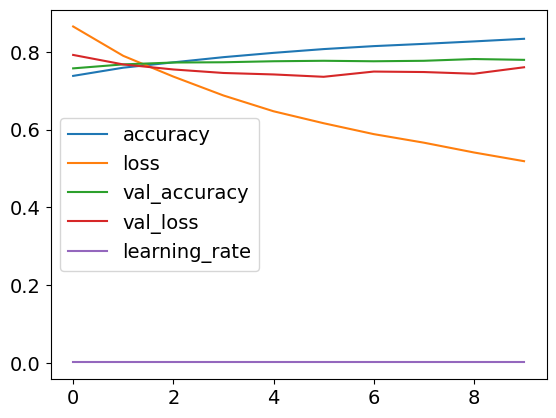

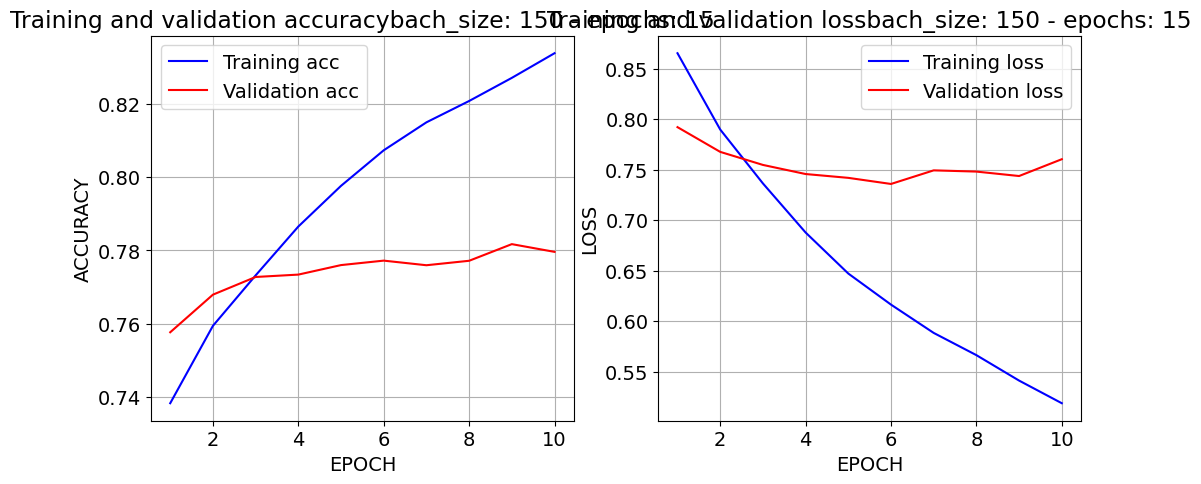

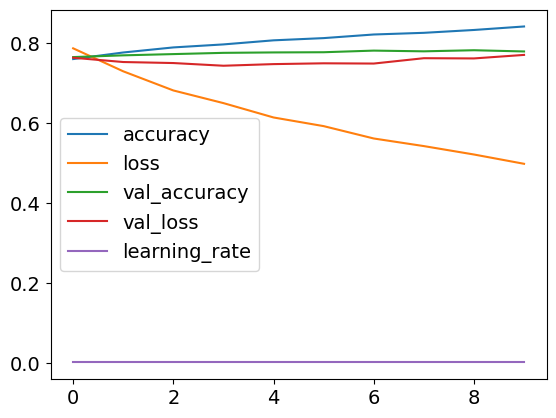

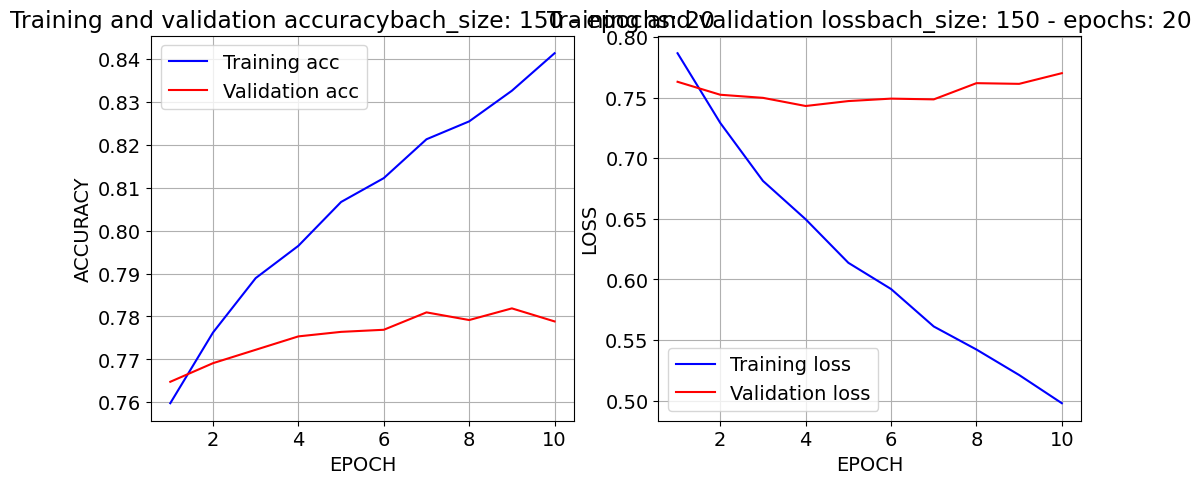

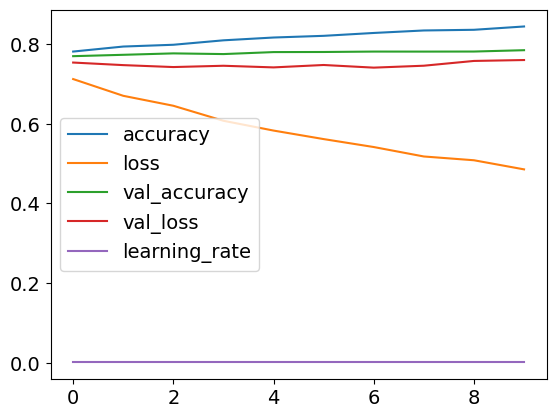

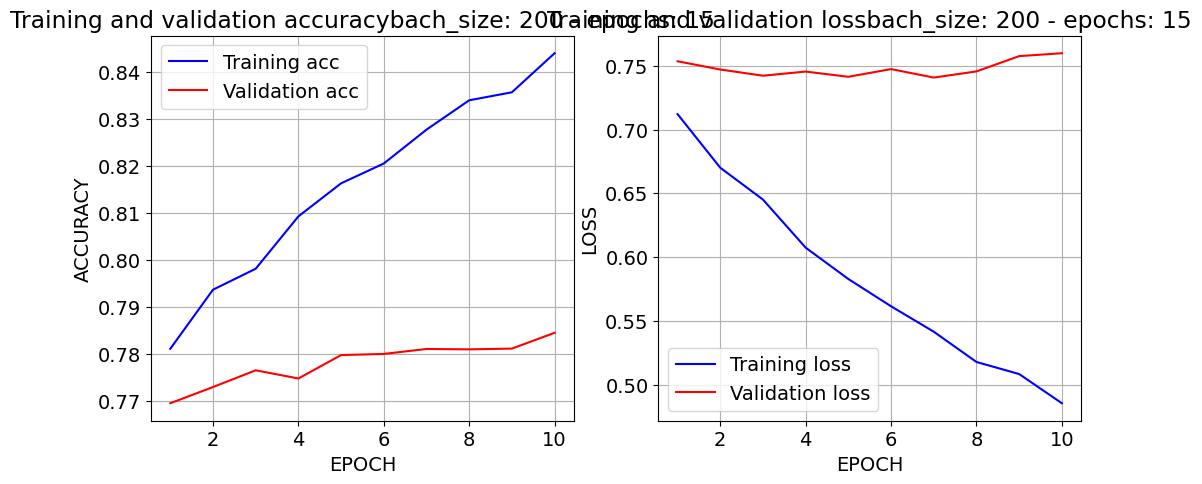

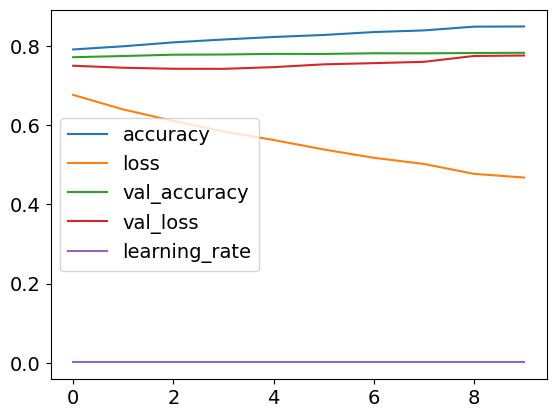

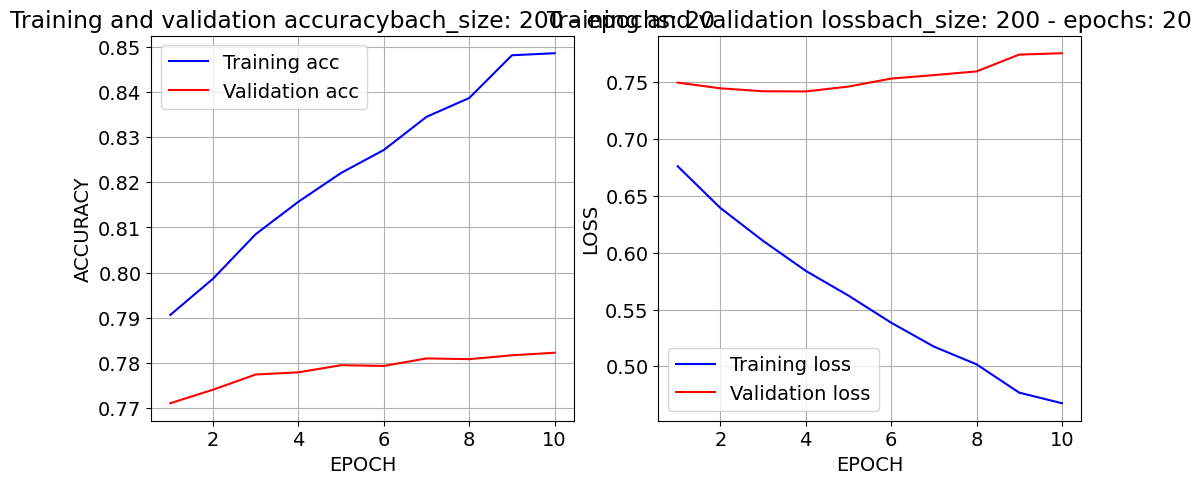

In [41]:
print('Training progress:')

history_text = []
for bach_size in [150, 200]:
    for epochs in [15, 20]:
        print("=>EPOCHS: " + str(epochs) + " =>bach_size: " + str(bach_size) )
        h = model_text.fit(train_x, y_train, 
                            epochs = epochs, batch_size= bach_size, 
                            validation_data=(val_x, y_test),
                            callbacks = callbacks)
        history_text.append (h)
        if hasattr(h, 'history_'):
            pd.DataFrame(h.history_).plot()
        else:
            pd.DataFrame(h.history).plot()
            
        plot_history(h, cols={'acc': 'accuracy', 'val_acc': 'val_accuracy', 'loss': 'loss', 'val_loss': 'val_loss'},
                    title= '\nbach_size: '+ str(bach_size) + ' - '+ 'epochs: ' + str(epochs))

        
        
#history_text = model_text_1.fit(train_x, y_train, 
#                    validation_data=(val_x, y_test))

#history_text = model_text_2.fit(train_x, y_train, 
#                    validation_data=(val_x, y_test))

>Save results to csv file

In [40]:
for h in history_text:
   print( h.history )

{'accuracy': [0.5378657579421997, 0.7015889286994934, 0.7400190830230713, 0.7631848454475403, 0.7772857546806335, 0.7908309698104858, 0.8006078004837036, 0.8069983720779419, 0.8178344964981079, 0.8221238255500793], 'loss': [1.6268913745880127, 1.0064105987548828, 0.8676632642745972, 0.7819309830665588, 0.727200984954834, 0.6793156266212463, 0.641377329826355, 0.6125206351280212, 0.58122318983078, 0.5584361553192139], 'val_accuracy': [0.710494339466095, 0.7492706775665283, 0.7587115168571472, 0.7675040364265442, 0.7715559005737305, 0.7724473476409912, 0.775526762008667, 0.7771880030632019, 0.7785656452178955, 0.782374382019043], 'val_loss': [0.9787305593490601, 0.8395178318023682, 0.7923121452331543, 0.764240562915802, 0.7462084293365479, 0.7494057416915894, 0.7391371130943298, 0.7457080483436584, 0.7493600845336914, 0.7400691509246826], 'learning_rate': [0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974

In [39]:

#1 Save results
best_loss = 10000
best_val_loss = 10000
best = None
best_index = -1
df = pd.DataFrame()
for h in history_text:
    #print(h.history)
    df = pd.concat([pd.DataFrame.from_dict(h.history), df], axis=0)
    # best
    if (min(h.history['val_loss']) < best_val_loss):
        best_loss = min(h.history['loss'])
        best_val_loss = min(h.history['val_loss'])
        best_index = np.argmin(np.array(h.history['val_loss']))
        best = h

print (f"best :\n{best}")
print("best index=", best_index)
print ("accuracy=", best.history['accuracy'][best_index])
print ("val_accuracy=", best.history['val_accuracy'][best_index])
print ("loss=", best.history['loss'][best_index])
print ("val_loss=", best.history['val_loss'][best_index] )

display(df.head())

hist_csv_file = f"{data_root_folder}\models\historie_LSTM_GLOVE.csv"
with open(hist_csv_file, mode='w') as f:
    df.to_csv(f)

best :
best index= 6
accuracy= 0.8006078004837036
val_accuracy= 0.775526762008667
loss= 0.641377329826355
val_loss= 0.7391371130943298


<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\m'
C:\Users\abdel\AppData\Local\Temp\ipykernel_7028\2083056804.py:26: SyntaxWarning: invalid escape sequence '\m'
  hist_csv_file = f"{data_root_folder}\models\historie_LSTM_GLOVE.csv"


accuracy      loss  val_accuracy  val_loss  learning_rate
0  0.701433  1.009198      0.746637  0.841819          0.001
1  0.740471  0.867405      0.759522  0.791994          0.001
2  0.762629  0.782576      0.761912  0.772063          0.001
3  0.777720  0.729520      0.769165  0.754458          0.001
4  0.786403  0.685300      0.773379  0.749738          0.001

>Afficher les performances train/test

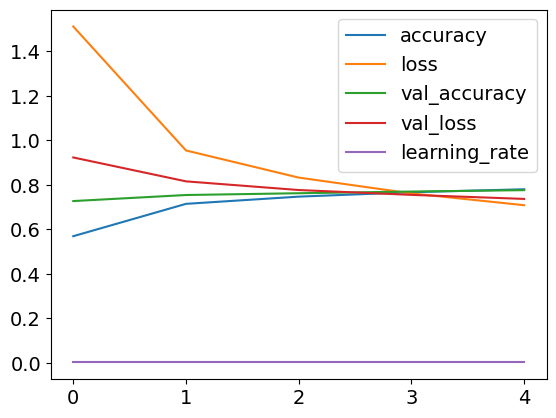

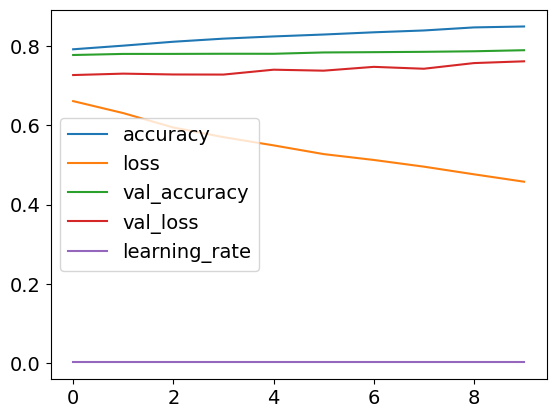

In [19]:
for h in history_text:
    pd.DataFrame(h.history).plot()

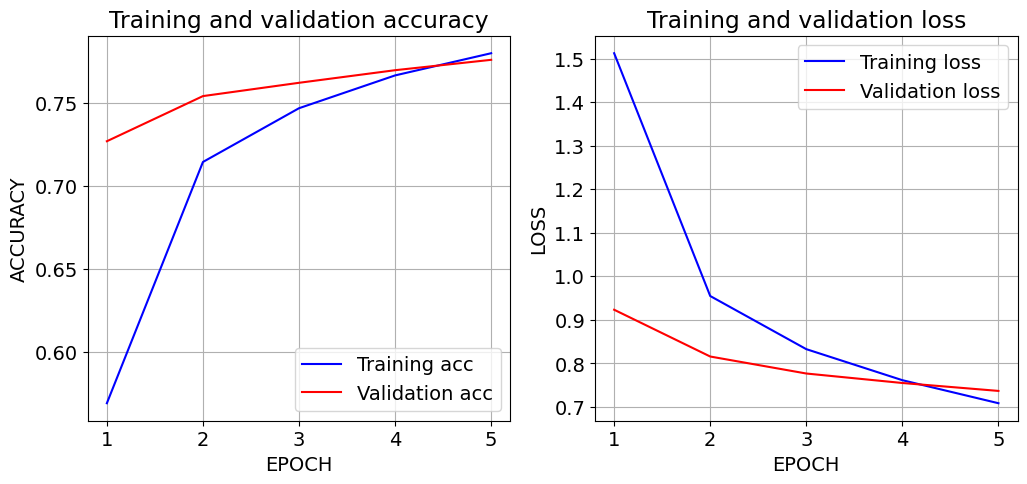

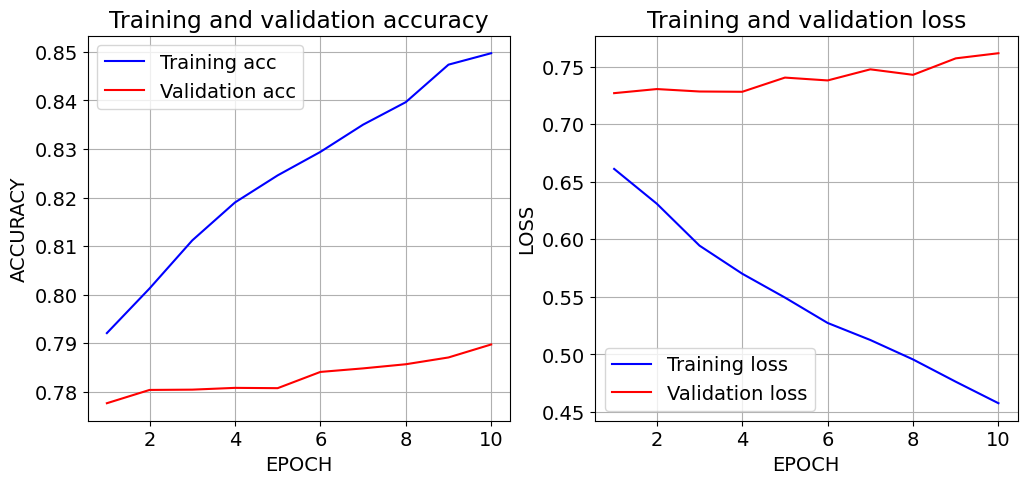

In [20]:
for h in history_text:
    plot_history(h, cols={'acc': 'accuracy', 'val_acc': 'val_accuracy', 'loss': 'loss', 'val_loss': 'val_loss'})


>Sauvegarde des **prédictions**

In [22]:
## prédire la catégorie avec la probabilité de chaque classe
pred_glove = model_text.predict(val_x)
pred_glove = pd.DataFrame(pred_glove)
pred_glove = pred_glove*100
pred_glove =  pred_glove.round(4)
pred_glove.to_csv(f'{data_root_folder}/models/pred_glove.csv', index = False)

515/515 ━━━━━━━━━━━━━━━━━━━━ 36s 69ms/step


In [24]:
np.unique( np.sort(pred_glove.values))

array([0.00000e+00, 1.00000e-04, 2.00000e-04, ..., 9.99990e+01,
       9.99992e+01, 9.99994e+01], dtype=float32)

In [23]:
pred_glove.head(10)

0        1       2       3       4        5       6       7       8   \
0   1.2948   0.0268  0.0000  0.0000  0.0000   0.0064  0.0014  0.0002  0.0568   
1   0.0027   0.0006  0.0132  0.0001  0.0000   0.0000  0.0002  0.0146  0.0002   
2   0.0000   0.0000  0.0000  0.0000  0.0000   0.0000  0.0000  0.0004  0.0001   
3   0.0027   0.0003  0.0138  0.0097  0.2317   0.0003  0.0128  0.2537  0.0179   
4  13.3026   2.3508  0.0487  0.0343  1.1544   3.1920  0.5951  0.1063  0.3568   
5   1.2323   0.0784  0.0004  0.0000  0.0008   0.3149  0.0137  0.0058  0.4747   
6   1.1371   0.5166  0.0277  0.0045  0.0766   0.0135  0.6090  0.7382  0.4731   
7  10.3527  16.8437  0.3632  0.1666  0.9487  41.0448  2.2234  0.3686  3.5688   
8   4.5960   0.3063  0.0069  0.0011  0.0099   0.0264  0.4316  0.0672  0.1991   
9  22.8887   0.4330  0.0003  0.0006  0.0070   0.0943  0.0220  0.0027  0.1003   

       9   ...      17         18       19      20      21         22  \
0  0.0003  ...  0.0001   0.204200   0.1151  0.0007  0.0000   0.000000   
1  0.0360  ...  0.0172   0.000000   0.0000  0.0000  0.0043  91.685501   
2  0.0007  ...  0.0000   0.000000   0.0000  0.0000  0.0001   0.005900   
3  0.0008  ...  0.0025   0.003500   0.0012  0.0011  0.0490   0.213400   
4  0.1341  ...  0.0083  51.676899  12.7005  0.1747  0.0236   0.015400   
5  0.0018  ...  0.0004   0.212200   0.1733  0.0054  0.0001   0.000100   
6  0.0391  ...  0.2638   0.531500   0.3633  0.0211  0.1290   1.116600   
7  0.1253  ...  0.0747   9.022100   6.3094  1.4743  0.3556   0.129900   
8  0.0105  ...  0.1959   2.071600   1.7982  0.0022  0.0517   6.890000   
9  0.0096  ...  0.0007  38.620300  26.1966  0.0059  0.0175   0.000400   

          23      24         25      26  
0   0.000300  0.0002  98.284798  0.0075  
1   0.096300  2.3515   0.000000  0.0002  
2  99.973602  0.0016   0.000000  0.0000  
3   0.001500  0.0062   0.000100  0.0000  
4   0.005000  0.0257  13.655400  0.0107  
5   0.004600  0.0017  97.430496  0.0469  
6   0.458500  0.1841   0.285400  0.0007  
7   0.075900  0.1572   5.451100  0.2012  
8   0.095200  0.0888   1.470800  0.0038  
9   0.000000  0.0002  11.590100  0.0006  

[10 rows x 27 columns]

> Calcul de **F1_score** sur Texte

In [28]:
y_pred_glove=np.argmax(model_text.predict(val_x), axis=-1)
classif_report = classification_report_imbalanced(y_test, y_pred_glove, output_dict = True)
classif_report = pd.DataFrame(classif_report).transpose()
display(classif_report)




515/515 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step


pre           rec           spe            f1  \
0                  0.436027      0.432387      0.978870      0.434199   
1                  0.576402      0.614433      0.986285      0.594810   
2                  0.783505      0.837466      0.994779      0.809587   
3                  0.860606      0.893082      0.998588      0.876543   
4                  0.724280      0.737945      0.991612      0.731049   
5                  0.822892      0.898684      0.990633      0.859119   
6                  0.714286      0.394737      0.998528      0.508475   
7                  0.646992      0.601901      0.979943      0.623632   
8                  0.665625      0.498829      0.993323      0.570281   
9                  0.820856      0.905605      0.986978      0.861150   
10                 0.916667      0.811475      0.999449      0.860870   
11                 0.767206      0.767206      0.992794      0.767206   
12                 0.791602      0.767722      0.991514      0.779479   
13                 0.815951      0.814286      0.988367      0.815117   
14                 0.871915      0.916049      0.993032      0.893438   
15                 0.826923      0.871622      0.998344      0.848684   
16                 0.768665      0.781818      0.985823      0.775186   
17                 0.865772      0.801242      0.998772      0.832258   
18                 0.629088      0.773545      0.972208      0.693878   
19                 0.676404      0.657205      0.981464      0.666667   
20                 0.801653      0.636066      0.997027      0.709324   
21                 0.898406      0.913880      0.993405      0.906077   
22                 0.755869      0.668050      0.993488      0.709251   
23                 0.961660      0.962165      0.994983      0.961912   
24                 0.783673      0.780488      0.993359      0.782077   
25                 0.761693      0.618445      0.993270      0.682635   
26                 1.000000      0.988304      1.000000      0.994118   
avg_pre            0.777527      0.777527      0.777527      0.777527   
avg_rec            0.777670      0.777670      0.777670      0.777670   
avg_spe            0.989170      0.989170      0.989170      0.989170   
avg_f1             0.775544      0.775544      0.775544      0.775544   
avg_geo            0.872942      0.872942      0.872942      0.872942   
avg_iba            0.755454      0.755454      0.755454      0.755454   
total_support  16453.000000  16453.000000  16453.000000  16453.000000   

                        geo           iba           sup  
0                  0.650577      0.400121    599.000000  
1                  0.778464      0.583472    485.000000  
2                  0.912740      0.819988    363.000000  
3                  0.944363      0.882412    159.000000  
4                  0.855427      0.713194    477.000000  
5                  0.943539      0.882080    760.000000  
6                  0.627818      0.370357    152.000000  
7                  0.768003      0.567531    947.000000  
8                  0.703917      0.470996    427.000000  
9                  0.945417      0.886539   1017.000000  
10                 0.900571      0.795783    122.000000  
11                 0.872742      0.744496    494.000000  
12                 0.872472      0.744172    663.000000  
13                 0.897114      0.790803    980.000000  
14                 0.953764      0.902664    810.000000  
15                 0.932833      0.859151    148.000000  
16                 0.877915      0.755011    935.000000  
17                 0.894572      0.784451    161.000000  
18                 0.867206      0.737106    945.000000  
19                 0.803133      0.624108    916.000000  
20                 0.796351      0.611284    305.000000  
21                 0.952813      0.900634    987.000000  
22                 0.814678      0.642100    482.000000  
23                 0.978436      0.954196   1903.000000  
24                

> Graphe de la f1_score par catégorie produit

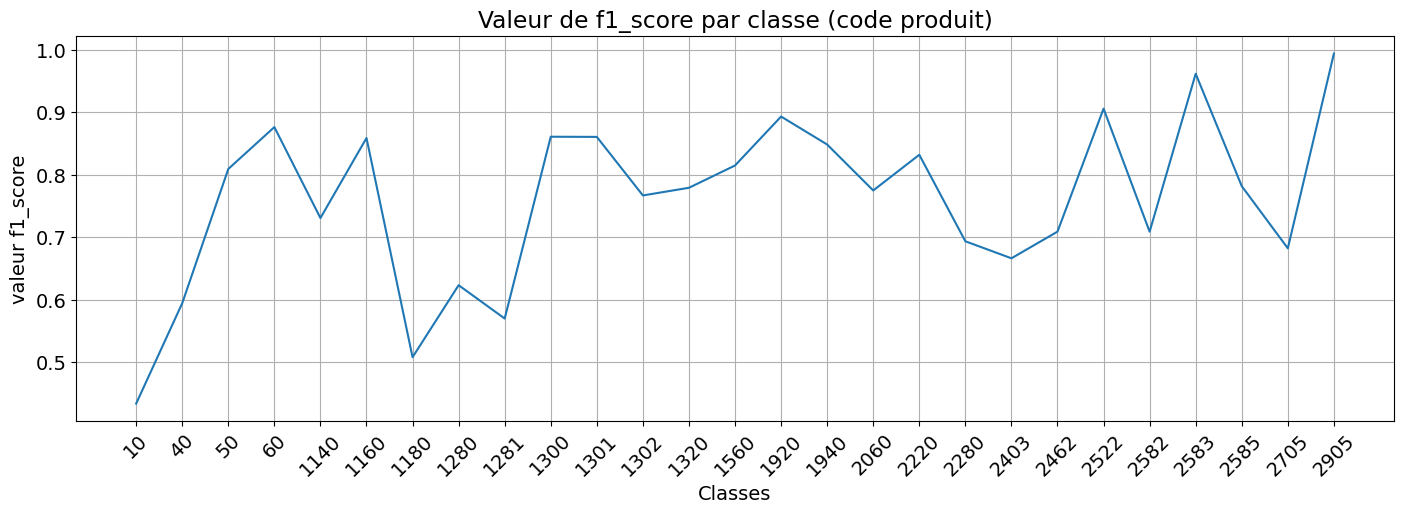

In [31]:
fig, ax = plt.subplots(1,1,figsize=(17, 5))

g = sns.lineplot(x=range(0, 27), y=classif_report.iloc[:27, 3], ax=ax)
g.set_title("Valeur de f1_score par classe (code produit)")
g.grid(True)
g.set_xticks(range(0, 27, 1))
g.set_xlabel("Classes")
g.set_ylabel("valeur f1_score")
g.set_xticklabels(unique_prod_codes, rotation=45)
plt.show()

>Confusion Matrix

0    1    2    3    4    5   6    7    8    9   ...   17   18   19   20  \
0   259   34    0    0    3   19   1    8    5    2  ...    0  132   84    0   
1    40  298   21    2   10   18   6    8    9    7  ...    0   20   14   18   
2     0   11  304    1    8    2   0    4    1    9  ...    0    1    0   13   
3     0    1    5  142    0    0   0    0    0    1  ...    0    1    0    7   
4     4   20    5    0  352   14   4   37    3    3  ...    0   10    8    0   
5    18   16    3    0    4  683   2    3    6    0  ...    0    7    7    0   
6     3   14    2    0   14   14  60    7   11    3  ...    0    5    1    2   
7    13   11   10    0   51    5   2  570   35  140  ...    5    2    8    0   
8    19   23    3    0    6   20   6   85  213    3  ...    0    4    9    5   
9     9    6    5    0    4    1   2   30    0  921  ...    0    8    6    0   
10    0    1    0    1    0    0   0    1    1    1  ...    0    1    0    1   
11    3    1    3    0    1    1   0   45    8    9  ...    0    3    3    0   
12    3    2    3    0    4    3   0   30    3    2  ...    3    4    2    0   
13    1    0    2    1    0    0   0    5    0    0  ...    4    0    0    0   
14    0    0    0    0    2    0   0    5    0    0  ...    0    0    0    0   
15    0    0    0    0    0    0   0    2    0    0  ...    1    3    1    0   
16    3    1    0    0    8    5   0   15    3    2  ...    3    4    0    0   
17    1    0    0    0    1    0   0    6    0    0  ...  129    1    1    0   
18   58   11    0    0    2    8   1    1    1    7  ...    0  731   89    0   
19   70   15    0    0    6   15   0    5    6    4  ...    0  155  602    2   
20    2   38   21   18    5    5   0    4    8    1  ...    0    1    3  194   
21    7    3    0    0    4    6   0    3    3    0  ...    0   11   11    0   
22    0    0    0    0    1    0   0    1    0    1  ...    3    2    0    0   
23    0    0    0    0    0    0   0    3    0    2  ...    0    0    0    0   
24    4    1    1    0    0    0   0    3    0    4  ...    0    0    0    0   
25   77    9    0    0    0   11   0    0    3    0  ...    1   56   41    0   
26    0    1    0    0    0    0   0    0    1    0  ...    0    0    0    0   

     21   22    23   24   25   26  
0     3    0     2    2   38    0  
1     1    1     1    0    7    0  
2     1    0     0    2    0    0  
3     0    0     0    1    0    0  
4     3    0     0    0    0    0  
5     0    1     0    1    7    0  
6     7    0     1    0    1    0  
7    12    1     4    4    1    0  
8     6    0     1    0    5    0  
9     0    3     4    5    0    0  
10    0    0     0    2    0    0  
11    4    8    13    1    0    0  
12    6    6     2    7    0    0  
13   16   35     2    8    0    0  
14    2    3     2    1    0    0  
15    2    2     1    1    1    0  
16   11   13     5   10    0    0  
17    1    3     2    5    0    0  
18    4    1     0    0   23    0  
19    6    0     1    1   23    0  
20    0    0     2    0    1    0  
21  902    1     3    6    0    0  
22    5  322     9   32    0    0  
23    4   10  1831   15    0    0  
24    7   16    17  384    0    0  
25    1    0     1    2  342    0  
26    0    0     0    0    0  169  

[27 rows x 27 columns]

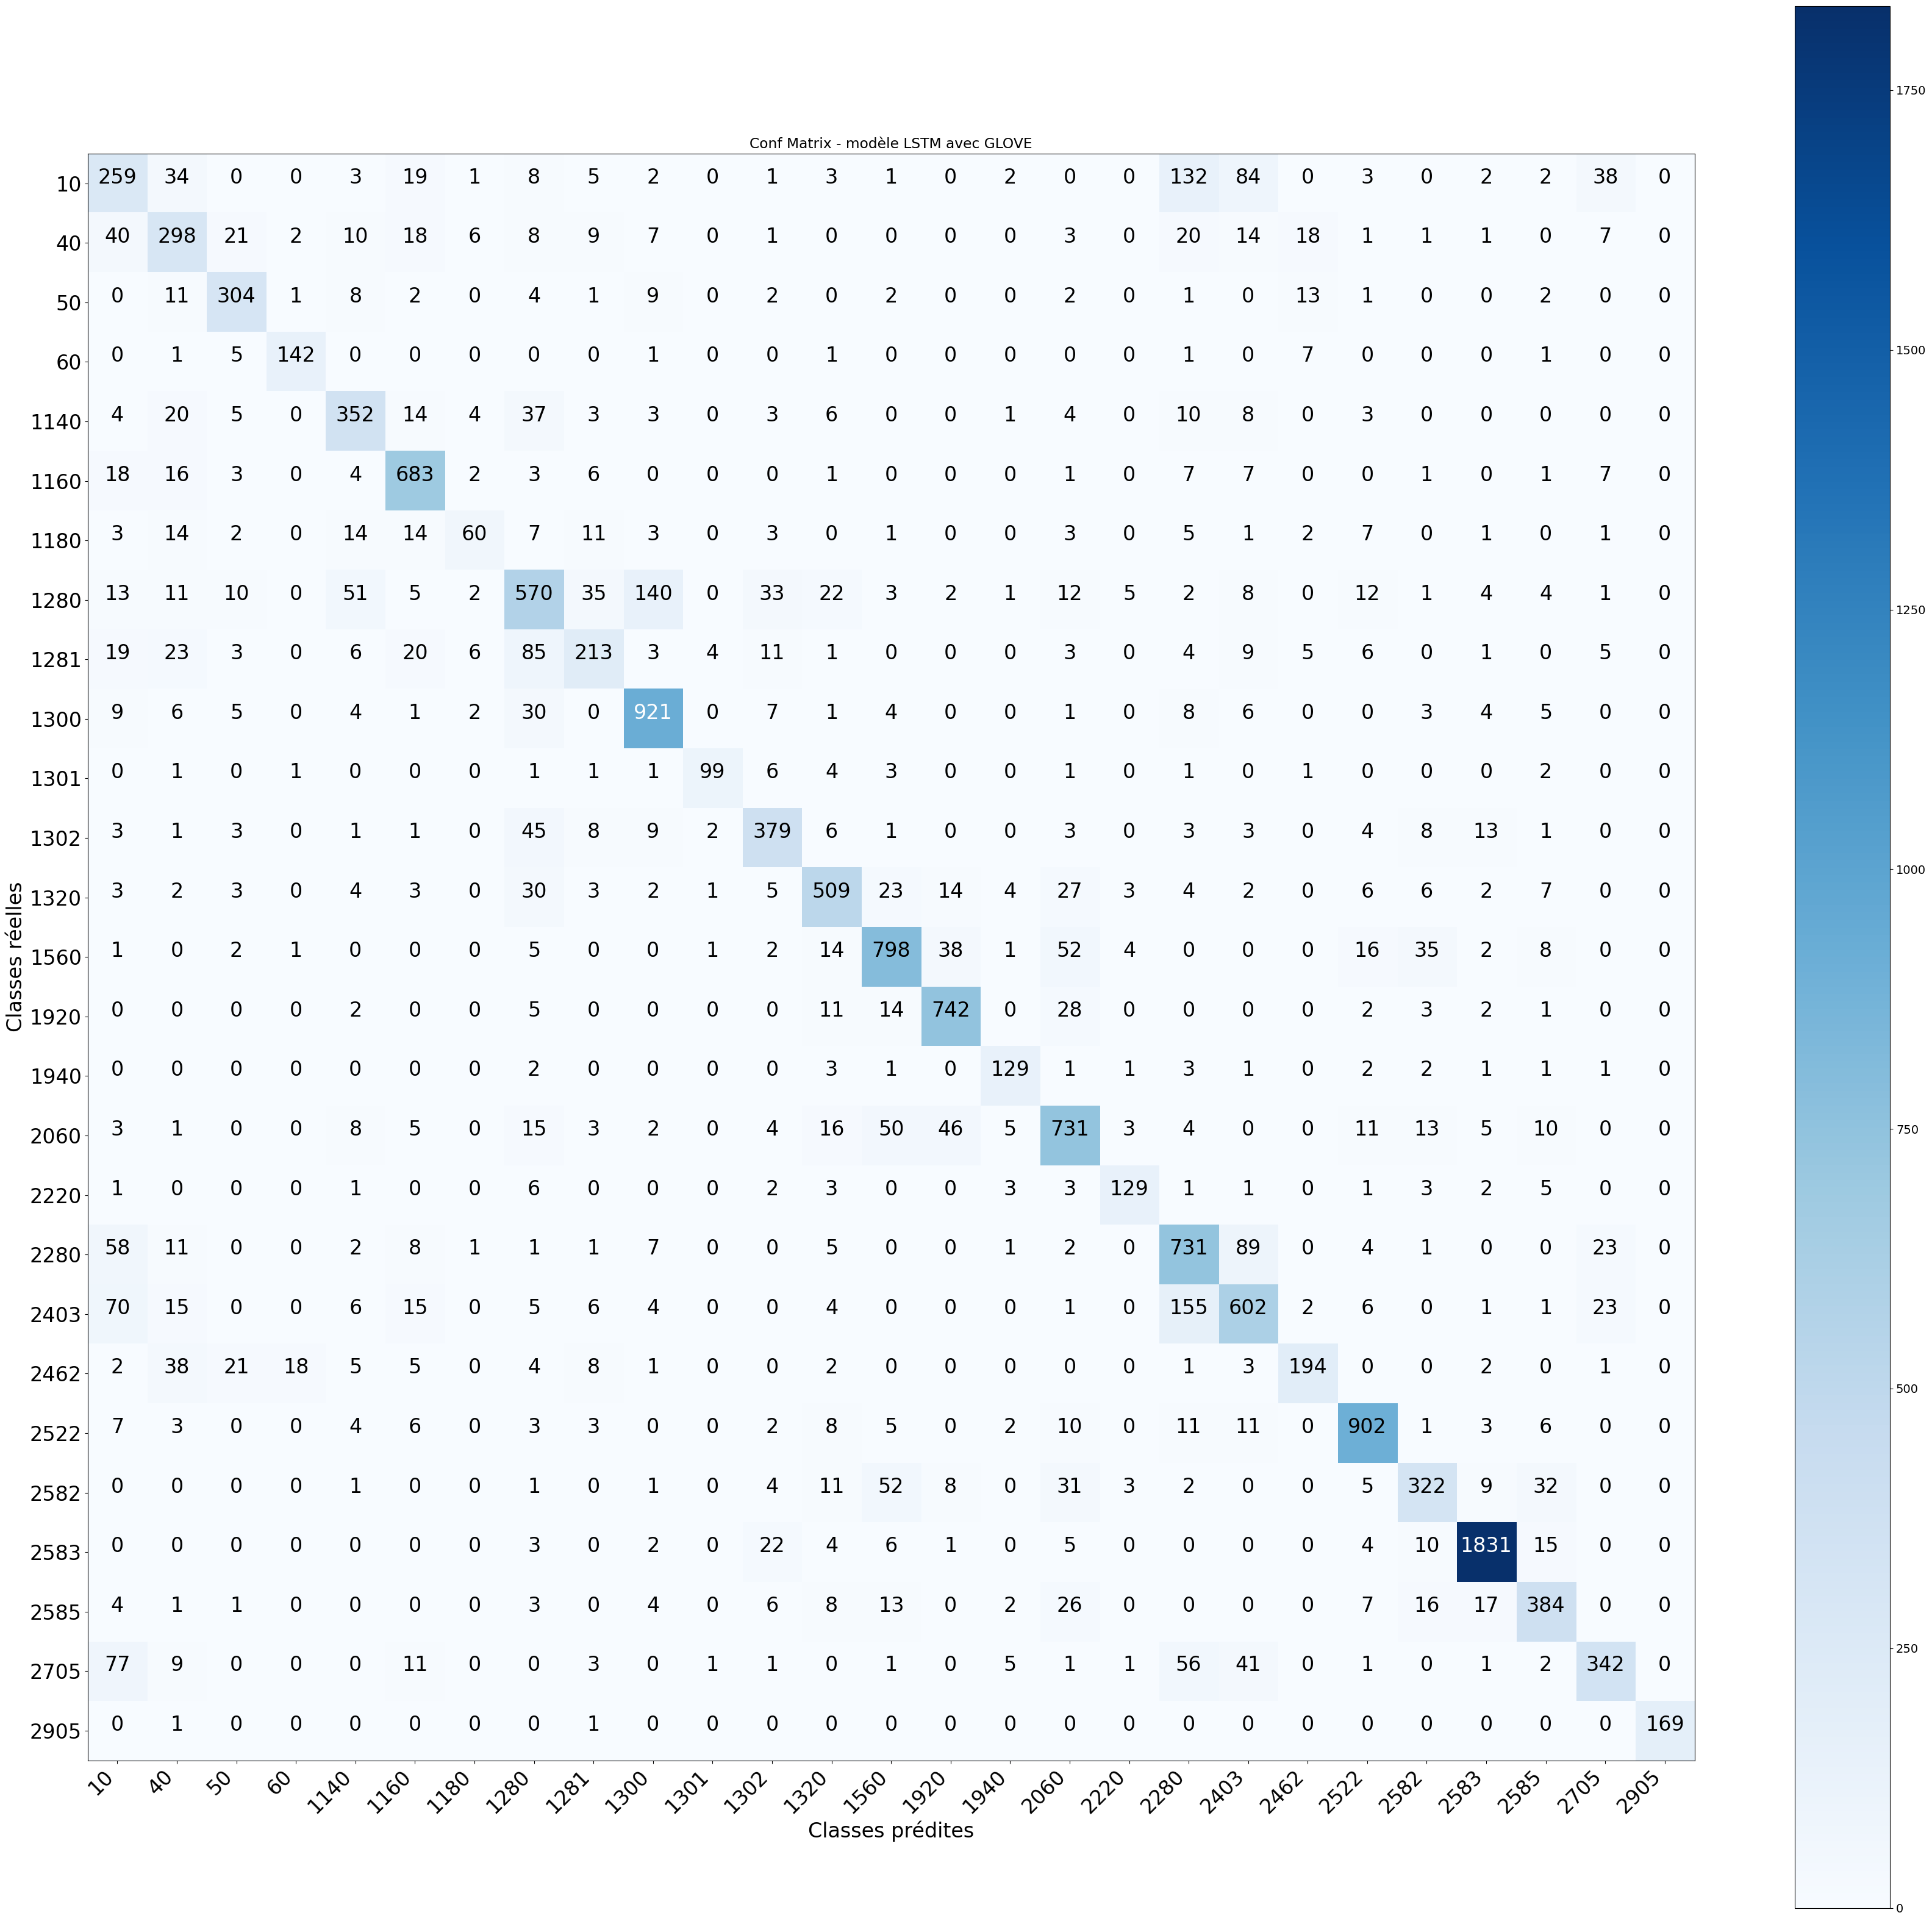

In [49]:
get_conf_matrix(y_true=y_test, y_pred=y_pred_glove, classes= unique_prod_codes, title="Conf Matrix - modèle LSTM avec GLOVE")


### <a name="text_others"> 🚀C1.2 Modèles sans set pre-entraîné</a>

>Hyperparamètres

In [10]:
## hyperparamètres texte
MAX_SEQUENCE_LENGTH = 500  # dimension max du padding (2ème dimension)
MAX_NB_WORDS = 60000 # nbre max de mots à tokeniser
EMBEDDING_DIM = 250    # embedding dimensions for word vectors 
GLOVE_DIR = "glove.6B."+str(EMBEDDING_DIM)+"d.txt"

>Tokenisation

>Définir training et test set **train_text**, **test_text** 

In [11]:

tokenizer = Tokenizer(num_words = MAX_NB_WORDS)

tokenizer.fit_on_texts(X_text_train['desi_desc'])
# Get our train data word index
train_word_index = tokenizer.word_index
tokenizer.fit_on_texts(X_text_test['desi_desc'])
# Get our test data word index
test_word_index = tokenizer.word_index

# Get max train/test sequence length
maxlen_train = max([len(x) for x in X_text_train['desi_desc']])
maxlen_test = max([len(x) for x in X_text_test['desi_desc']])
minlen_train = min([len(x) for x in X_text_train['desi_desc']])
minlen_test = min([len(x) for x in X_text_test['desi_desc']])
print("maxlen_train sentence =", maxlen_train)
print("minlen_train sentence =", minlen_train)
print("maxlen_test sentence =", maxlen_test)
print("minlen_test sentence =", minlen_test)
print("="*20)

# get train/test tokenization
train_text_seq = tokenizer.texts_to_sequences(X_text_train['desi_desc'])
test_text_seq = tokenizer.texts_to_sequences(X_text_test['desi_desc'])
train_text = tf.keras.utils.pad_sequences(train_text_seq, maxlen= min(maxlen_train, MAX_SEQUENCE_LENGTH))
test_text = tf.keras.utils.pad_sequences(test_text_seq, maxlen= min(maxlen_test, MAX_SEQUENCE_LENGTH))

# Adding 1 because of reserved Keras 0 index
vocab_size = len(tokenizer.word_index) + 1  

print(f"type(train_text): {type(train_text)}")
print("="*20)
print("train_text.shape=", train_text.shape)
print("test_text.shape=", test_text.shape)
print("="*20)
print(f'Found unique tokens (vocab_size): {vocab_size}')
print("="*20)
print(f"Train text length : {len(train_text)}")
print(f"Test text length: {len(test_text)}")

#pd.DataFrame(tokenizer.word_index, index=[0]).hist()


maxlen_train sentence = 6133
minlen_train sentence = 0
maxlen_test sentence = 6349
minlen_test sentence = 0
type(train_text): <class 'numpy.ndarray'>
train_text.shape= (65812, 500)
test_text.shape= (16453, 500)
Found unique tokens (vocab_size): 152714
Train text length : 65812
Test text length: 16453


#### 🚀Les modèles

In [15]:

def create_lstm_model_text():
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding_layer = Embedding(input_dim= vocab_size, 
                                output_dim= EMBEDDING_DIM, 
                                input_length= MAX_SEQUENCE_LENGTH)
                                
    embedded_sequences = embedding_layer(sequence_input)
    x = LSTM(10, return_sequences=True, name='lstm_layer', activation='tanh')(embedded_sequences)  # hidden_nodes = 10
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(10, activation="relu")(x)
    x = Dropout(0.2)(x)
    output = Dense(units= n_classes, activation="softmax")(x)
    
    return Model(sequence_input, output)
    

def create_conv1d_model_text():       
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH, ))
    embedding_layer= Embedding(input_dim= vocab_size, 
                                output_dim= EMBEDDING_DIM, 
                                input_length= MAX_SEQUENCE_LENGTH)
    x = embedding_layer(  sequence_input  )
    x = SpatialDropout1D(0.2)(x)
    x = Conv1D(64, 2, activation='relu')(x)
    x = GlobalMaxPool1D()(x)
    output = Dense(units= n_classes, activation='softmax')(x)
    
    return Model(sequence_input, output)


def create_conv1d_model_text_1(): 
    # 3 - Neural network model design
    print('Building conv1D model')
    filters = 64
    kernel_size = 2
    hidden_dims = 256
    
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH, ))
    embedding_layer= Embedding(input_dim= vocab_size, 
                                output_dim= EMBEDDING_DIM)
    x = embedding_layer(  sequence_input  )
    x = Conv1D(filters,
             kernel_size,
             padding='valid',
             activation='relu',
             strides=1)(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(hidden_dims)(x)
    x = Activation('relu')(x)
    output = Dense(n_classes, activation='softmax')(x)
     
    return Model(sequence_input, output)


print("-----LSTM model--------------------------------------------") 
lstm_model_text = create_lstm_model_text()
lstm_model_text.summary()
lstm_model_text.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy', 
                        metrics=['accuracy'])

print("-----conv1D model--------------------------------------------")  
conv1D_model_text = create_conv1d_model_text()
conv1D_model_text.summary()
conv1D_model_text.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy', 
                        metrics=['accuracy'])
                                                            

print("-----conv1D model_1-------------SGD= Stochastic gradient descent => pas de résultats probants et trop long !")  
#conv1D_model_text_1 = create_conv1d_model_text_1()
#conv1D_model_text_1.summary()
#conv1D_model_text_1.compile(optimizer="SGD",
#                        loss='sparse_categorical_crossentropy', 
#                        metrics=['accuracy'])

print("-----conv1D model_1-------------adam-----------")  
conv1D_model_text_1 = create_conv1d_model_text_1()
conv1D_model_text_1.summary()
conv1D_model_text_1.compile(optimizer="adam",
                        loss='sparse_categorical_crossentropy', 
                        metrics=['accuracy'])



-----LSTM model--------------------------------------------


d:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 500, 250)       │    38,178,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 500, 10)        │        10,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 10)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 27)             │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,189,347 (145.68 MB)

 Trainable params: 38,189,347 (145.68 MB)

 Non-trainable params: 0 (0.00 B)

-----conv1D model--------------------------------------------


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 500, 250)       │    38,178,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 500, 250)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 499, 64)        │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 27)             │         1,755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,212,319 (145.77 MB)

 Trainable params: 38,212,319 (145.77 MB)

 Non-trainable params: 0 (0.00 B)

-----conv1D model_1-------------SGD= Stochastic gradient descent => pas de résultats probants et trop long !
-----conv1D model_1-------------adam-----------
Building conv1D model


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 500, 250)       │    38,178,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 499, 64)        │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_5          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 27)             │         6,939 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,234,143 (145.85 MB)

 Trainable params: 38,234,143 (145.85 MB)

 Non-trainable params: 0 (0.00 B)

##### 🚀Modèle **LSTM**

-----CONVD1 model_1--------------------------------------------
Training progress:
=>EPOCHS: 7 =>bach_size: 50
Epoch 1/7
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 313s 237ms/step - accuracy: 0.5124 - loss: 1.7228 - val_accuracy: 0.7724 - val_loss: 0.7720 - learning_rate: 0.0010
Epoch 2/7
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 300s 228ms/step - accuracy: 0.8683 - loss: 0.4358 - val_accuracy: 0.7828 - val_loss: 0.7646 - learning_rate: 0.0010
Epoch 3/7
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 302s 230ms/step - accuracy: 0.9496 - loss: 0.1742 - val_accuracy: 0.7784 - val_loss: 0.8777 - learning_rate: 0.0010
Epoch 4/7
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 306s 232ms/step - accuracy: 0.9719 - loss: 0.0979 - val_accuracy: 0.7749 - val_loss: 1.0377 - learning_rate: 0.0010
Epoch 5/7
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 304s 231ms/step - accuracy: 0.9810 - loss: 0.0691 - val_accuracy: 0.7704 - val_loss: 1.1393 - learning_rate: 0.0010
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
=>EPOCHS: 10 =>bach_s

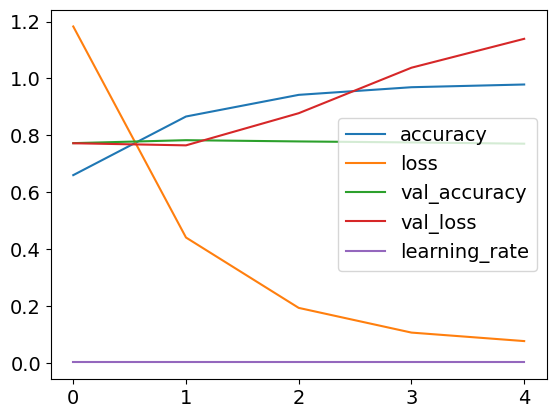

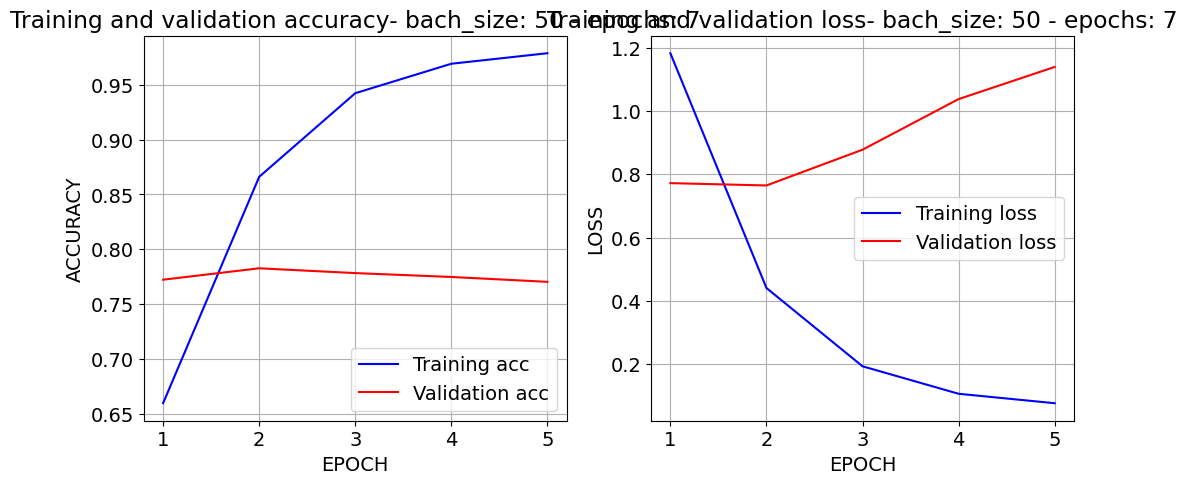

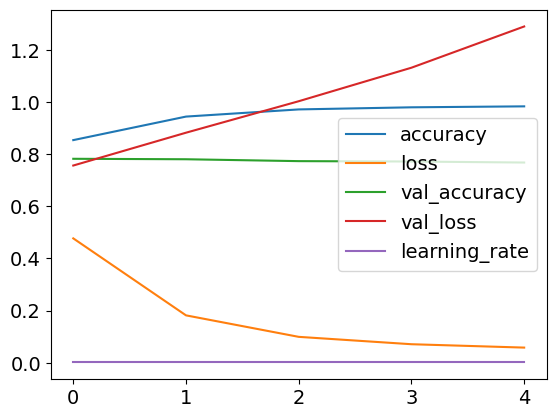

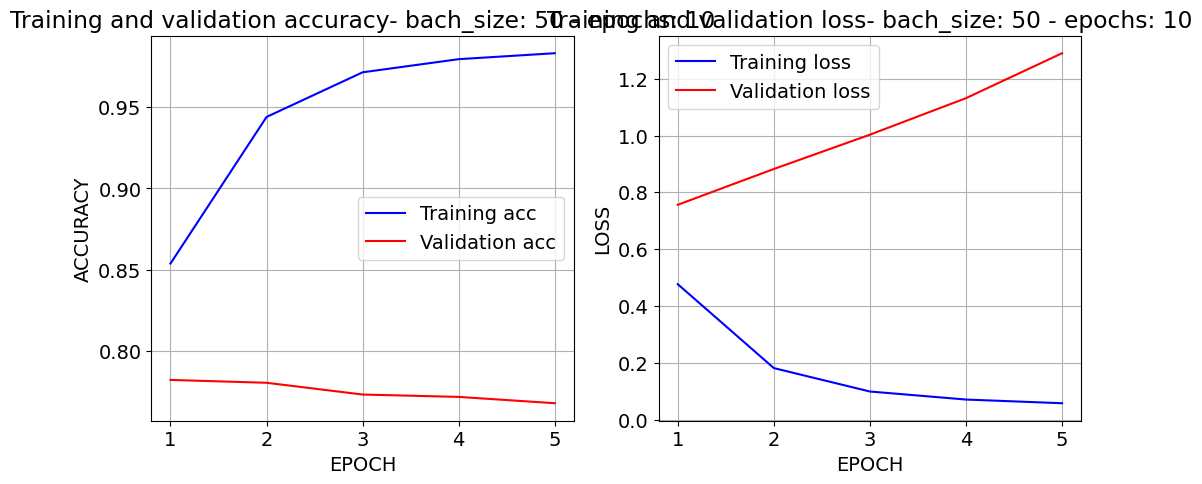

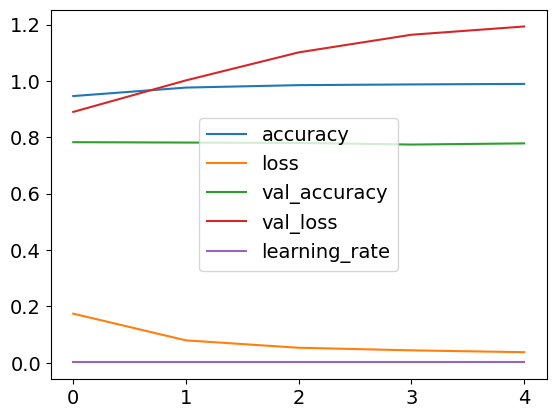

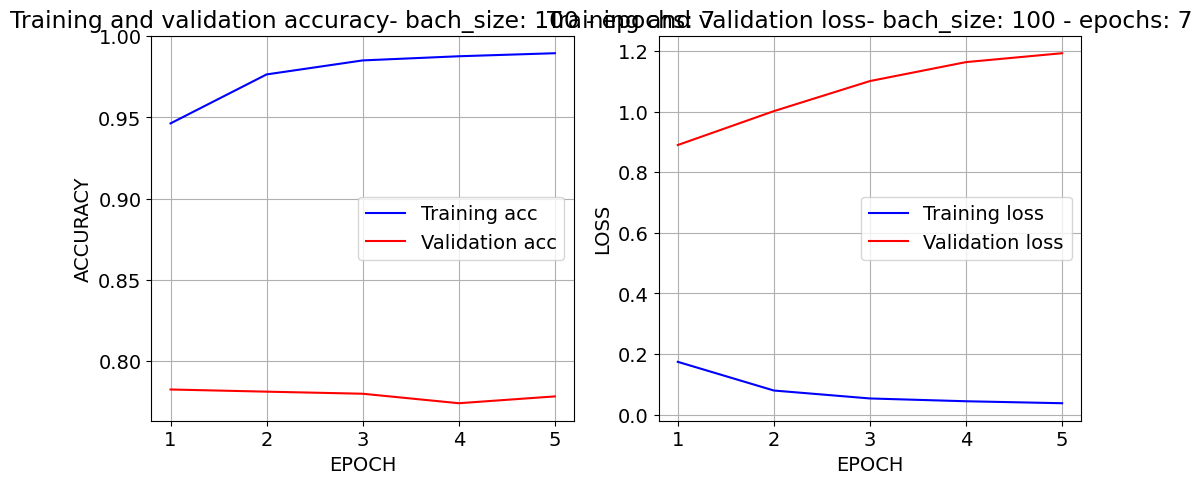

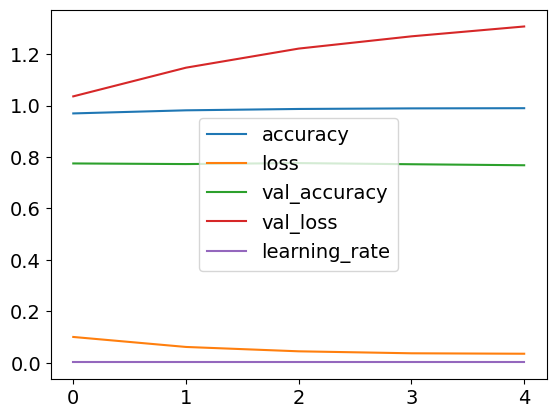

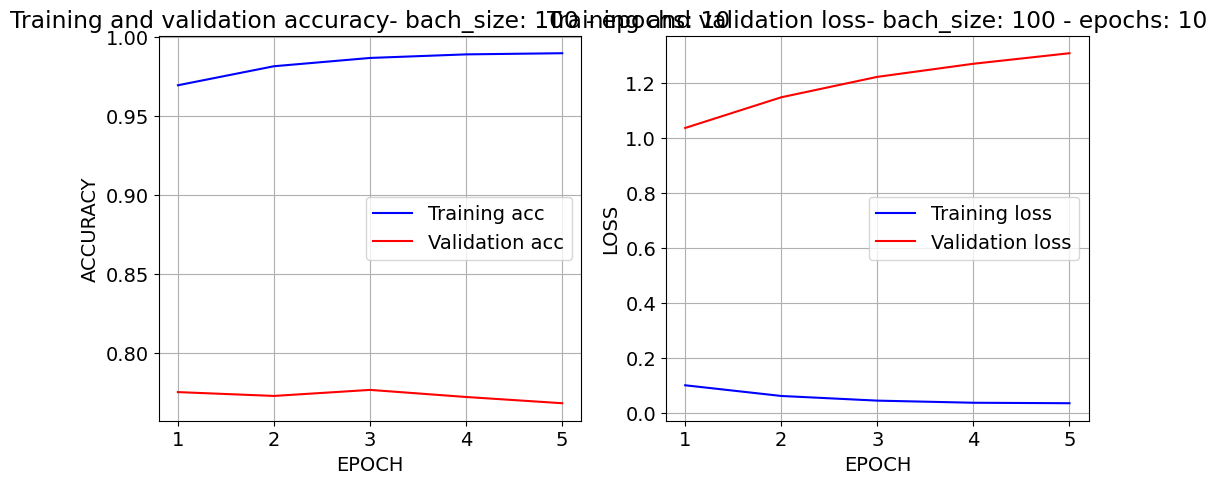

In [16]:

print("-----CONVD1 model_1--------------------------------------------") 
print('Training progress:')
for bach_size in [50, 100]:
    for epochs in [7, 10]:
        print("=>EPOCHS: " + str(epochs) + " =>bach_size: " + str(bach_size) )
        h = conv1D_model_text_1.fit(train_text, y_train, 
                            epochs= epochs, batch_size= bach_size,
                            verbose= True,
                            validation_data=(test_text, y_test),
                            callbacks = callbacks)
        pd.DataFrame(h.history).plot()
        plot_history(h, cols={'acc': 'accuracy', 'val_acc': 'val_accuracy', 'loss': 'loss', 'val_loss': 'val_loss'},
                    title= '- bach_size: '+ str(bach_size) + ' - '+ 'epochs: ' + str(epochs))


>Save model

In [14]:
conv1D_model_text_1.save(f"{data_root_folder}/models/conv1D_model_text_1.h5") 

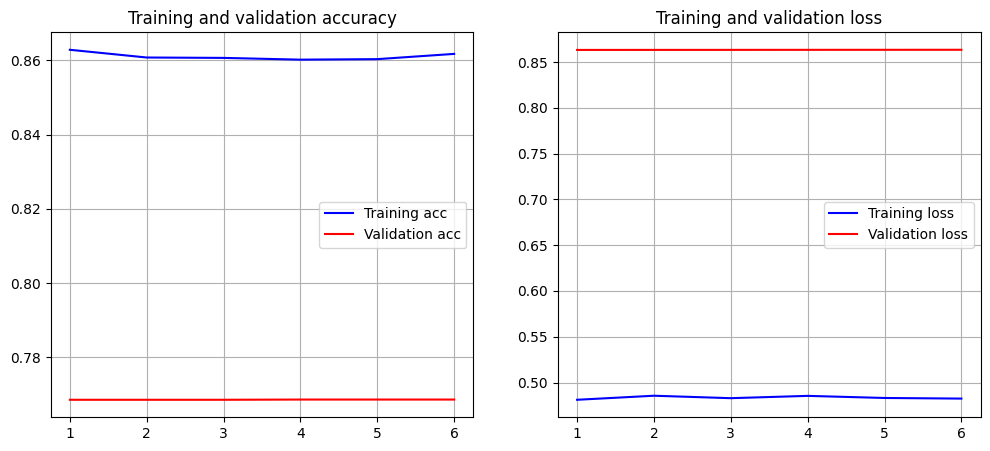

In [28]:

plot_history(history_lstm_model_text, cols={'acc': 'accuracy', 'val_acc': 'val_accuracy', 'loss': 'loss', 'val_loss': 'val_loss'})


>Sauvegarde des **prédictions**

In [81]:

get_predictions(conv1D_model_text_1, save_to_csv=False,csv_file_name="conv1D_model_text_1.csv")


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(16453, 27)


0             1             2             3         4   \
0  2.451759e-01  9.885363e-04  2.133601e-04  9.537484e-07  0.001908   
1  4.157469e-06  4.164820e-05  2.500888e-03  3.331622e-08  0.000026   
2  4.044848e-08  7.508523e-05  1.488306e-04  2.905370e-08  0.000007   
3  2.480997e-07  3.221377e-07  8.804324e-07  4.502756e-11  0.000087   
4  2.511148e-01  5.180292e-03  2.700778e-05  5.600311e-05  0.001641   

             5             6         7         8         9   ...  \
0  3.559297e-06  2.147461e-04  0.013699  0.004186  0.011661  ...   
1  2.714880e-11  7.275098e-05  0.000535  0.000352  0.000070  ...   
2  2.643704e-09  1.856479e-05  0.000335  0.000036  0.000123  ...   
3  2.888527e-11  2.850038e-07  0.000277  0.000060  0.000011  ...   
4  2.873645e-03  1.066422e-03  0.000557  0.001163  0.000123  ...   

             17            18            19            20        21        22  \
0  9.237204e-06  2.034589e-02  1.419801e-02  1.034449e-04  0.000052  0.002852   
1  2.160279e-03  1.623904e-08  6.975094e-07  1.446948e-07  0.000016  0.900108   
2  3.960020e-03  1.724555e-09  2.693304e-08  3.245264e-08  0.000004  0.001117   
3  2.580220e-05  8.388643e-06  3.328063e-07  1.711877e-09  0.000040  0.000747   
4  8.568587e-07  1.896357e-01  2.010718e-01  1.140397e-03  0.000185  0.000005   

             23        24            25            26  
0  1.453063e-06  0.000899  6.513150e-01  9.225582e-06  
1  1.050745e-03  0.006620  1.936568e-06  3.859501e-06  
2  9.812855e-01  0.001875  1.938108e-09  9.376125e-09  
3  8.853259e-07  0.001742  6.674779e-07  4.082715e-08  
4  7.906755e-07  0.000042  3.434861e-01  8.190551e-06  

[5 rows x 27 columns]

> Calcul de **F1_score** sur la partie texte

In [87]:
classif_report = get_classif_report(conv1D_model_text_1, test_text, y_test)
display(classif_report)
    

515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


pre           rec           spe            f1  \
0                  0.458075      0.492487      0.977987      0.474658   
1                  0.642202      0.577320      0.990230      0.608035   
2                  0.815562      0.779614      0.996022      0.797183   
3                  0.957447      0.849057      0.999632      0.900000   
4                  0.689139      0.771488      0.989609      0.727992   
5                  0.832134      0.913158      0.991079      0.870765   
6                  0.644628      0.513158      0.997362      0.571429   
7                  0.641717      0.678986      0.976848      0.659826   
8                  0.682635      0.533958      0.993386      0.599212   
9                  0.863992      0.868240      0.990995      0.866111   
10                 0.918919      0.836066      0.999449      0.875536   
11                 0.756863      0.781377      0.992230      0.768924   
12                 0.850877      0.731523      0.994617      0.786699   
13                 0.761518      0.860204      0.982938      0.807858   
14                 0.913771      0.876543      0.995717      0.894770   
15                 0.849315      0.837838      0.998651      0.843537   
16                 0.753637      0.831016      0.983632      0.790437   
17                 0.802721      0.732919      0.998220      0.766234   
18                 0.685714      0.711111      0.980139      0.698182   
19                 0.636364      0.710699      0.976057      0.671480   
20                 0.723333      0.711475      0.994860      0.717355   
21                 0.927273      0.878419      0.995603      0.902185   
22                 0.853211      0.578838      0.996995      0.689740   
23                 0.976242      0.950079      0.996976      0.962983   
24                 0.701169      0.853659      0.988785      0.769936   
25                 0.715556      0.582278      0.991950      0.642074   
26                 0.982659      0.994152      0.999816      0.988372   
avg_pre            0.784768      0.784768      0.784768      0.784768   
avg_rec            0.780283      0.780283      0.780283      0.780283   
avg_spe            0.989501      0.989501      0.989501      0.989501   
avg_f1             0.779987      0.779987      0.779987      0.779987   
avg_geo            0.875447      0.875447      0.875447      0.875447   
avg_iba            0.757997      0.757997      0.757997      0.757997   
total_support  16453.000000  16453.000000  16453.000000  16453.000000   

                        geo           iba           sup  
0                  0.694007      0.458262    599.000000  
1                  0.756095      0.548074    485.000000  
2                  0.881200      0.759709    363.000000  
3                  0.921273      0.835964    159.000000  
4                  0.873769      0.746819    477.000000  
5                  0.951321      0.897960    760.000000  
6                  0.715405      0.487022    152.000000  
7                  0.814412      0.643510    947.000000  
8                  0.728304      0.506057    427.000000  
9                  0.927589      0.849859   1017.000000  
10                 0.914114      0.821952    122.000000  
11                 0.880514      0.758958    494.000000  
12                 0.852986      0.708443    663.000000  
13                 0.919526      0.835150    980.000000  
14                 0.934232      0.862388    810.000000  
15                 0.914717      0.823252    148.000000  
16                 0.904109      0.804939    935.000000  
17                 0.855345      0.712205    161.000000  
18                 0.834858      0.678237    945.000000  
19                 0.832876      0.675275    916.000000  
20                 0.841319      0.687760    305.000000  
21                 0.935178      0.864309    987.000000  
22                 0.759670      0.552967    482.000000  
23                 0.973245      0.942764   1903.000000  
24                

>Tracer la courbe f1_score pour les 27 classes

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


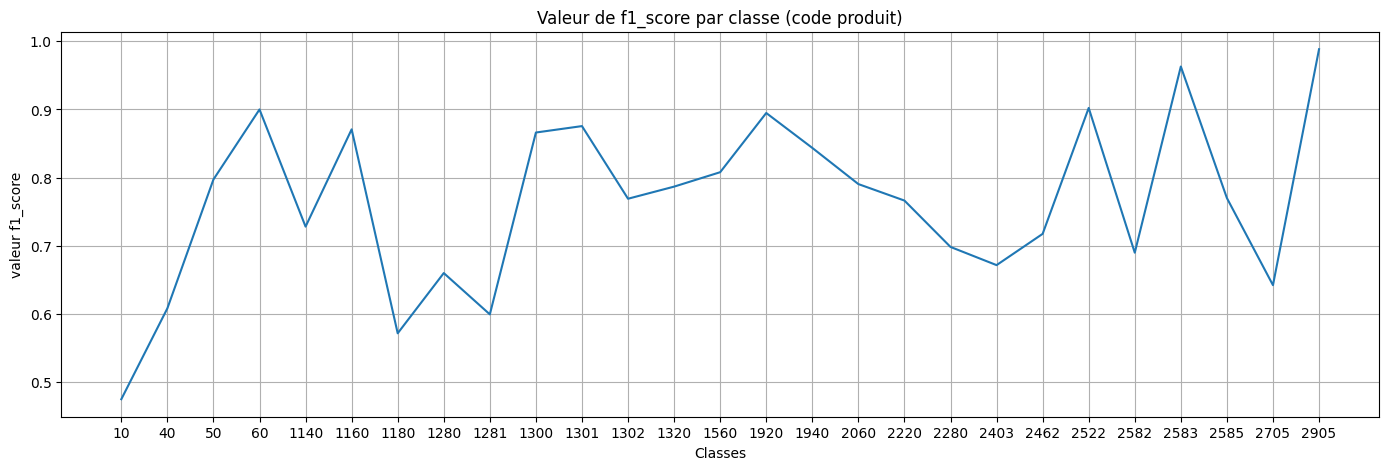

In [88]:
fig, ax = plt.subplots(1,1,figsize=(17, 5))

g = sns.lineplot(x=range(0, 27), y=classif_report.iloc[:27, 3], ax=ax)
g.set_title("Valeur de f1_score par classe (code produit)")
g.grid(True)
g.set_xticks(range(0, 27, 1))
g.set_xlabel("Classes")
g.set_ylabel("valeur f1_score")
g.set_xticklabels(unique_prod_codes)
plt.show()


La courbe f1_score est trop instable relativement aux différentes classes, signe d'un désiquilbre du dataset. Cela est aussi constaté au travers l'accuracy et les marges d'erreur qui ne diminuent pas pour le dataset de test, contrairement à celui du tarining. Nous optons dans la section qui suite pour un équilibrage du dataset après vevtorisation en utilisant la librairie **SMOTE**.

>Evaluer le modèle

In [101]:
%%time
#Get the accuracy score and loss values
accuracy, loss = evaluate_model(conv1D_model_text_1, test_text, y_test, batch_size=50)
print("Accuracy: {:.2f}%".format(accuracy)) 
print("Loss: ", loss)


549/549 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7779 - loss: 0.7658
Accuracy: 78.03%
Loss:  0.764776349067688
CPU times: user 1.67 s, sys: 222 ms, total: 1.89 s
Wall time: 1.45 s


> Exemples de prédictions

In [ ]:
desc = ["Je souhaite acheter une poupée ou un jeu vidéo pour l'anniversaire de ma fille."]
seq = tokenizer.texts_to_sequences(desc)
padded = pad_sequences(seq, maxlen=len(desc))
pred = conv1D_model_text_1.predict(padded)
labels = range(0, 27)
print(pred, labels[np.argmax(pred)])

#### <a name="conv1"></a>🚀Model1 : conv1D

In [29]:
EMBEDDING_DIM = 500
def create_conv1d_model_text():
    model_conv1D = Sequential()
    
    model_conv1D.add(Input(shape=(MAX_SEQUENCE_LENGTH, ) ) )
    
    model_conv1D.add(Embedding(input_dim= vocab_size, output_dim=EMBEDDING_DIM))
    model_conv1D.add(SpatialDropout1D(0.2))
    model_conv1D.add(Conv1D(64, 2, activation='relu'))
    model_conv1D.add(GlobalMaxPool1D())
    model_conv1D.add(Dense(units= n_classes, activation='softmax'))
     
    return model_conv1D


model_conv1D= create_conv1d_model_text()

model_conv1D.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 500, 500)       │    76,357,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ (None, 500, 500)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 499, 64)        │        64,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 27)             │         1,755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,422,819 (291.53 MB)

 Trainable params: 76,422,819 (291.53 MB)

 Non-trainable params: 0 (0.00 B)

>Optimizer classe Adam

In [31]:

# 1
learning_rate =  0.001
model_conv1D.compile(optimizer= Adam(learning_rate= learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [1]:
# fit the model
print('Training progress:')
history_text = []
for bach_size in [50]:
    for epochs in [5, 10]:
        print("=>EPOCHS: " + str(epochs) + " =>bach_size: " + str(bach_size) )
        h = model_conv1D.fit(x_train, y_train, epochs= epochs, batch_size= bach_size, 
                 validation_data=(x_test, y_test),
                callbacks= callbacks)
        history_text.append (h)
        if hasattr(h, 'history_'):
            pd.DataFrame(h.history_).plot()
        elif hasattr(h, 'history'):
            pd.DataFrame(h.history).plot()
        plot_history(h, cols={'acc': 'accuracy', 'val_acc': 'val_accuracy', 'loss': 'loss', 'val_loss': 'val_loss'},
                    title= 'bach_size: '+ str(bach_size) + ' - '+ 'epochs: ' + str(epochs))

Training progress:
=>EPOCHS: 5 =>bach_size: 50


NameError: name 'model_conv1D' is not defined

> **Classification report**

In [22]:
classif_report = get_classif_report(model_conv1D, x_test, y_test)
display(classif_report)

NameError: name 'model_conv1D' is not defined

>f1_score graph by class

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


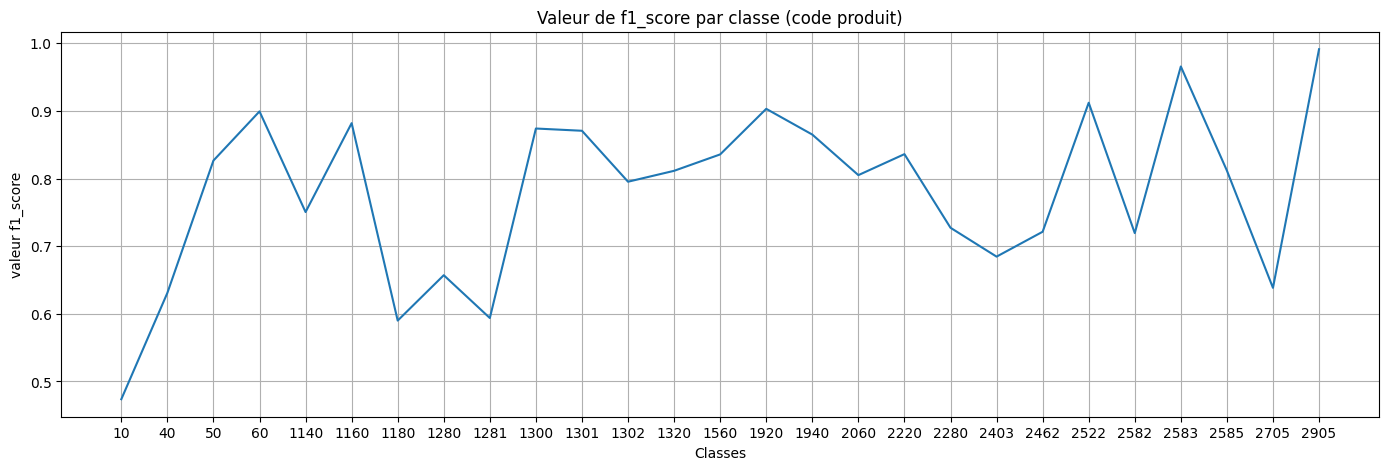

In [39]:
fig, ax = plt.subplots(1,1,figsize=(17, 5))

g = sns.lineplot(x=range(0, 27), y=classif_report.iloc[:27, 3], ax=ax)
g.set_title("Valeur de f1_score par classe (code produit)")
g.grid(True)
g.set_xticks(range(0, 27, 1))
g.set_xlabel("Classes")
g.set_ylabel("valeur f1_score")
g.set_xticklabels(unique_prod_codes)
plt.show()

> Précision globale

In [51]:
y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred)
print(list(y_test_class))
#print(list(y_pred_class))
mask = y_test_class - y_pred_class
print(list(mask))
n_OK, count_OK = np.unique(np.where(mask==0), return_counts= True)
n_KO, count_KO = np.unique(np.where(mask!=0), return_counts= True)      

print("--->N de bonnes prédictions =", len(count_OK))
print("--->N de mauvaises prédictions =", len(count_KO))
print("--->Précision (%) :", 100-round(100*len(count_KO)/len(count_OK), 0), "%")


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

ZeroDivisionError: division by zero

>Optimizer adam

Training progress:
==>filters: 256 ==>kernel_size: 2


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 500, 250)       │    38,178,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 500, 250)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 499, 256)       │       128,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 27)             │         6,939 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,313,695 (146.16 MB)

 Trainable params: 38,313,695 (146.16 MB)

 Non-trainable params: 0 (0.00 B)

=>EPOCHS: 10 =>bach_size: 50
Epoch 1/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 397s 301ms/step - accuracy: 0.5225 - loss: 1.7374 - val_accuracy: 0.7823 - val_loss: 0.7197 - learning_rate: 0.0010
Epoch 2/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 394s 299ms/step - accuracy: 0.8709 - loss: 0.4356 - val_accuracy: 0.7996 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 3/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 392s 298ms/step - accuracy: 0.9464 - loss: 0.1881 - val_accuracy: 0.7924 - val_loss: 0.7826 - learning_rate: 0.0010
Epoch 4/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 391s 297ms/step - accuracy: 0.9745 - loss: 0.0914 - val_accuracy: 0.7944 - val_loss: 0.8874 - learning_rate: 0.0010
Epoch 5/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 2742s 2s/step - accuracy: 0.9838 - loss: 0.0580 - val_accuracy: 0.7845 - val_loss: 0.9922 - learning_rate: 0.0010
Epoch 6/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 412s 313ms/step - accuracy: 0.9870 - loss: 0.0485 - val_accuracy: 0.7832 - val_loss: 1.1165 - learning_rate: 0.0010
Epoch 7/10
1317/1317 ━━━━

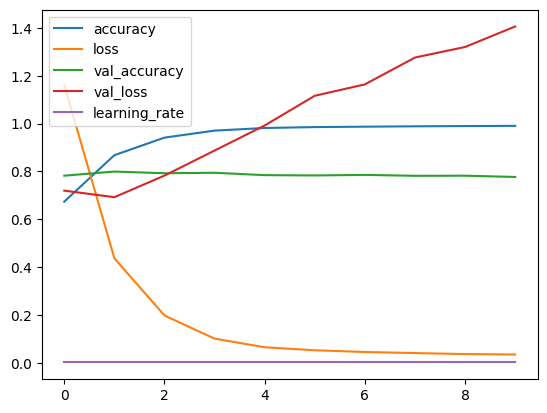

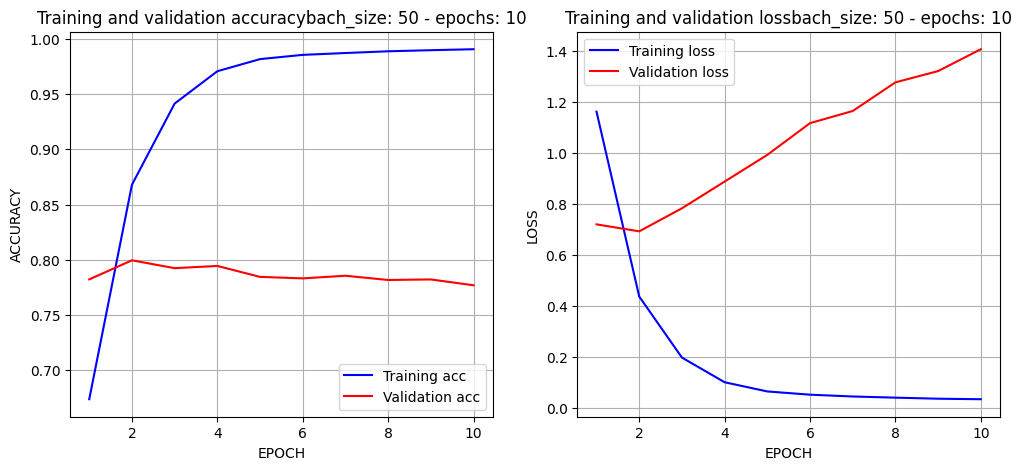

In [12]:
print('Training progress:')
history_text = []
for filters in [256]:
    for kernel_size in [2]:
        print(f"==>filters: {filters} ==>kernel_size: {kernel_size}")
        def create_conv1d_model_text():
            model_conv1D = Sequential()

            model_conv1D.add(Input(shape=(MAX_SEQUENCE_LENGTH, ) ) )

            model_conv1D.add(Embedding(input_dim= vocab_size, output_dim=EMBEDDING_DIM))
            model_conv1D.add(SpatialDropout1D(0.2))
            model_conv1D.add(Conv1D(filters, kernel_size, activation='relu'))
            model_conv1D.add(GlobalMaxPool1D())
            model_conv1D.add(Dense(units= n_classes, activation='softmax'))

            return model_conv1D

        model_conv1D= create_conv1d_model_text()
        model_conv1D.summary()
        model_conv1D.compile(optimizer= 'adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']
             )

        for bach_size in [50]:
            for epochs in [10]:
                print("=>EPOCHS: " + str(epochs) + " =>bach_size: " + str(bach_size) )
                h = model_conv1D.fit(x_train, y_train, epochs=epochs, batch_size=bach_size, 
                         validation_data=(x_test, y_test),
                        callbacks= callbacks)
                if hasattr(h, 'history_'):
                    pd.DataFrame(h.history_).plot()
                    h.history_['filters'] = filters
                    h.history_['kernel_size'] = kernel_size
                    h.history_['bach_size'] = bach_size
                    h.history_['epochs'] = epochs
                elif hasattr(h, 'history'):
                    pd.DataFrame(h.history).plot()
                    h.history['filters'] = filters
                    h.history['kernel_size'] = kernel_size
                    h.history['bach_size'] = bach_size
                    h.history['epochs'] = epochs
                
                history_text.append (h)
                
                plot_history(h, cols={'acc': 'accuracy', 'val_acc': 'val_accuracy', 'loss': 'loss', 'val_loss': 'val_loss'},
                            title= 'bach_size: '+ str(bach_size) + ' - '+ 'epochs: ' + str(epochs))

>Save results to csv file

In [22]:
#1 Save results
df = pd.DataFrame()
for h in history_text:
    #print(h.history)
    df = pd.concat([pd.DataFrame.from_dict(h.history), df], axis=0)
    
display(df)


hist_csv_file = f"{data_root_folder}\models\historie_conv1d.csv"
with open(hist_csv_file, mode='w') as f:
    df.to_csv(f)


<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
C:\Users\abdel\AppData\Local\Temp\ipykernel_24124\2328131790.py:10: SyntaxWarning: invalid escape sequence '\m'
  hist_csv_file = f"{data_root_folder}\models\historie_conv1d.csv"


accuracy      loss  val_accuracy  val_loss  learning_rate  filters  \
0  0.673798  1.161585      0.782289  0.719683          0.001      256   
1  0.867972  0.436860      0.799550  0.692334          0.001      256   
2  0.941439  0.197540      0.792439  0.782624          0.001      256   
3  0.970720  0.100749      0.794445  0.887384          0.001      256   
4  0.981690  0.064687      0.784538  0.992164          0.001      256   
5  0.985535  0.052014      0.783201  1.116460          0.001      256   
6  0.987206  0.044916      0.785571  1.164091          0.001      256   
7  0.988771  0.040353      0.781742  1.276357          0.001      256   
8  0.989759  0.036213      0.782228  1.320591          0.001      256   
9  0.990640  0.034210      0.776940  1.406294          0.001      256   

   kernel_size  bach_size  epochs  
0            2         50      10  
1            2         50      10  
2            2         50      10  
3            2         50      10  
4            2         50      10  
5            2         50      10  
6            2         50      10  
7            2         50      10  
8            2         50      10  
9            2         50      10

> Prédictions

In [47]:

# save predictions
y_pred_df = get_predictions(model_conv1D, x_test=x_test, save_to_csv=True, csv_file_name="conv1D_model_text_1.csv")
display(y_pred_df)
#pd.DataFrame(y_pred_df).hist()
print(pd.DataFrame(y_pred_df).shape)



#fig, ax = plt.subplots(1,1,figsize=(15, 7))
#sns.lineplot(data=y_pred_df, x=)

515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step
y_pred= [[9.7220205e-02 1.2101823e-03 1.5930316e-05 ... 1.2373204e-04
  8.8730592e-01 4.4225777e-05]
 [4.8611804e-07 1.2016027e-07 6.6762615e-05 ... 1.7518902e-03
  6.4905794e-06 1.3012661e-07]
 [3.5685121e-06 9.3093977e-06 2.1168085e-05 ... 2.6037018e-03
  8.6779573e-06 2.5041620e-06]
 ...
 [6.9485168e-08 1.0668246e-07 2.9693427e-05 ... 6.4597651e-04
  5.6861427e-07 5.1103081e-07]
 [1.5627438e-01 5.6806229e-02 6.0118330e-03 ... 3.1065983e-03
  1.7274606e-01 7.2133681e-04]
 [8.3630200e-04 6.1429063e-07 6.8488056e-08 ... 5.3501145e-07
  1.5082759e-04 6.1707510e-08]]


0             1             2             3             4   \
0      9.722020e-02  1.210182e-03  1.593032e-05  1.513958e-06  4.348819e-04   
1      4.861180e-07  1.201603e-07  6.676262e-05  4.352382e-08  6.911279e-07   
2      3.568512e-06  9.309398e-06  2.116809e-05  4.024631e-07  4.803153e-06   
3      2.468514e-06  1.428526e-06  2.176937e-05  1.827626e-07  1.053870e-04   
4      1.502181e-01  1.286045e-03  5.252195e-05  5.149089e-06  2.730714e-04   
...             ...           ...           ...           ...           ...   
16448  8.861727e-08  1.887716e-07  3.731919e-05  9.892908e-09  2.422173e-07   
16449  1.409538e-09  2.905077e-09  6.261786e-07  4.986199e-10  2.475003e-05   
16450  6.948517e-08  1.066825e-07  2.969343e-05  2.312770e-08  2.909354e-05   
16451  1.562744e-01  5.680623e-02  6.011833e-03  1.656750e-03  2.478608e-02   
16452  8.363020e-04  6.142906e-07  6.848806e-08  7.617053e-09  1.785129e-05   

                 5             6         7         8             9   ...  \
0      3.082793e-05  1.021447e-03  0.000733  0.002629  2.670368e-04  ...   
1      9.516162e-08  1.436221e-05  0.000002  0.000005  2.634519e-06  ...   
2      3.519208e-07  3.308036e-04  0.000322  0.000099  1.013760e-04  ...   
3      4.100253e-07  2.236977e-05  0.000093  0.000013  2.975734e-06  ...   
4      5.119779e-04  1.201989e-04  0.000061  0.000247  4.019643e-05  ...   
...             ...           ...       ...       ...           ...  ...   
16448  4.617294e-10  2.533824e-06  0.000023  0.000002  1.625675e-05  ...   
16449  6.975184e-12  1.515114e-07  0.002654  0.000004  5.077822e-08  ...   
16450  3.058736e-09  8.030179e-07  0.000322  0.000041  5.868681e-06  ...   
16451  1.730575e-01  1.584327e-02  0.010049  0.024833  2.776195e-03  ...   
16452  2.521289e-08  1.118189e-07  0.000012  0.000001  1.341862e-06  ...   

                 17            18            19            20        21  \
0      5.205259e-05  6.217303e-04  2.291948e-03  1.073251e-06  0.000326   
1      1.148240e-04  1.608085e-07  1.072951e-07  4.164857e-09  0.000006   
2      1.527597e-04  1.977022e-06  6.722034e-07  3.244045e-07  0.000111   
3      3.522510e-06  2.615829e-05  4.720254e-07  1.939887e-08  0.000048   
4      5.287151e-06  4.808807e-02  1.824903e-02  7.272479e-05  0.000247   
...             ...           ...           ...           ...       ...   
16448  3.606573e-04  1.282731e-07  3.147817e-08  1.390583e-09  0.000005   
16449  3.374655e-06  3.356479e-08  1.421505e-08  1.888339e-11  0.000015   
16450  3.923961e-05  4.634225e-07  2.335084e-07  1.011446e-09  0.000073   
16451  4.051923e-03  5.122924e-02  9.676202e-02  3.266884e-02  0.038610   
16452  1.724661e-07  9.980626e-01  8.936371e-04  3.856663e-08  0.000003   

             22            23            24            25            26  
0      0.000908  4.547496e-04  1.237320e-04  8.873059e-01  4.422578e-05  
1      0.996161  2.860793e-04  1.751890e-03  6.490579e-06  1.301266e-07  
2      0.000370  9.941556e-01  2.603702e-03  8.677957e-06  2.504162e-06  
3      0.000450  1.725440e-06  4.596852e-05  3.300655e-06  8.833275e-07  
4      0.000126  6.799779e-06  7.281913e-06  7.783704e-01  1.028230e-05  
...         ...           ...           ...           ...           ...  
16448  0.019725  1.357391e-04  9.790922e-01  1.617382e-07  1.576406e-07  
16449  0.000004  8.240343e-08  1.949566e-05  3.474895e-08  3.991304e-08  
16450  0.000320  2.911062e-06  6.459765e-04  5.686143e-07  5.110308e-07  
16451  0.001209  4.386227e-03  3.106598e-03  1.727461e-01  7.213368e-04  
16452  0.000001  4.476215e-08  5.350115e-07  1.508276e-04  6.170751e-08  

[16453 rows x 27 columns]

(16453, 27)


> Calcul de **F1_score** sur Texte

In [17]:
y_pred = np.argmax(model_conv1D.predict(x_test), axis=-1)
classif_report = classification_report_imbalanced(y_test, y_pred, output_dict = True)
classif_report = pd.DataFrame(classif_report).transpose()
display(classif_report)

515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step


pre           rec           spe            f1  \
0                  0.460270      0.512521      0.977293      0.484992   
1                  0.617761      0.659794      0.987600      0.638086   
2                  0.796438      0.862259      0.995028      0.828042   
3                  0.909091      0.880503      0.999141      0.894569   
4                  0.713402      0.725367      0.991299      0.719335   
5                  0.851401      0.919737      0.992226      0.884250   
6                  0.681034      0.519737      0.997730      0.589552   
7                  0.624446      0.744456      0.972656      0.679191   
8                  0.731788      0.517564      0.994946      0.606310   
9                  0.896378      0.876106      0.993327      0.886126   
10                 0.938053      0.868852      0.999571      0.902128   
11                 0.829787      0.789474      0.994987      0.809129   
12                 0.871622      0.778281      0.995187      0.822311   
13                 0.852697      0.838776      0.990823      0.845679   
14                 0.905707      0.901235      0.995142      0.903465   
15                 0.860927      0.878378      0.998712      0.869565   
16                 0.770732      0.844920      0.984856      0.806122   
17                 0.902098      0.801242      0.999141      0.848684   
18                 0.778598      0.669841      0.988393      0.720137   
19                 0.660606      0.713974      0.978374      0.686254   
20                 0.821138      0.662295      0.997275      0.733212   
21                 0.927625      0.921986      0.995409      0.924797   
22                 0.733906      0.709544      0.992236      0.721519   
23                 0.969953      0.966894      0.996082      0.968421   
24                 0.797297      0.839431      0.993421      0.817822   
25                 0.678707      0.645570      0.989371      0.661724   
26                 0.982659      0.994152      0.999816      0.988372   
avg_pre            0.803633      0.803633      0.803633      0.803633   
avg_rec            0.799550      0.799550      0.799550      0.799550   
avg_spe            0.990493      0.990493      0.990493      0.990493   
avg_f1             0.799791      0.799791      0.799791      0.799791   
avg_geo            0.887041      0.887041      0.887041      0.887041   
avg_iba            0.778824      0.778824      0.778824      0.778824   
total_support  16453.000000  16453.000000  16453.000000  16453.000000   

                        geo           iba           sup  
0                  0.707731      0.477603    599.000000  
1                  0.807225      0.630252    485.000000  
2                  0.926268      0.846581    363.000000  
3                  0.937948      0.869309    159.000000  
4                  0.847972      0.699934    477.000000  
5                  0.955294      0.905971    760.000000  
6                  0.720109      0.493770    152.000000  
7                  0.850940      0.707576    947.000000  
8                  0.717599      0.490366    427.000000  
9                  0.932877      0.860059   1017.000000  
10                 0.931923      0.857127    122.000000  
11                 0.886294      0.769373    494.000000  
12                 0.880076      0.757734    663.000000  
13                 0.911635      0.818442    980.000000  
14                 0.947025      0.888434    810.000000  
15                 0.936615      0.866691    148.000000  
16                 0.912209      0.820480    935.000000  
17                 0.894737      0.784711    161.000000  
18                 0.813675      0.640976    945.000000  
19                 0.835783      0.680064    916.000000  
20                 0.812706      0.638365    305.000000  
21                 0.957994      0.911015    987.000000  
22                 0.839068      0.684132    482.000000  
23                 0.981380      0.960295   1903.000000  
24                

>Graphe de la f1_score par catégorie produit

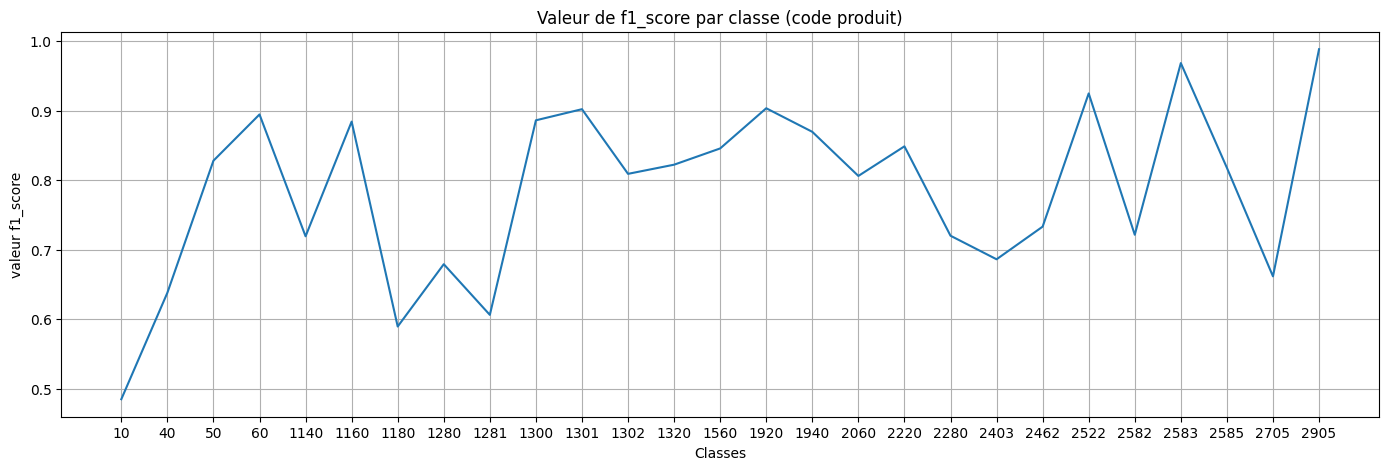

In [18]:
fig, ax = plt.subplots(1,1,figsize=(17, 5))

g = sns.lineplot(x=range(0, 27), y=classif_report.iloc[:27, 3], ax=ax)
g.set_title("Valeur de f1_score par classe (code produit)")
g.grid(True)
g.set_xticks(range(0, 27, 1))
g.set_xlabel("Classes")
g.set_ylabel("valeur f1_score")
g.set_xticklabels(unique_prod_codes)
plt.show()

>Confusion Matrix

0    1    2    3    4    5   6    7    8    9   ...   17   18   19   20  \
0   307   29    0    1    8   11   2    9    4    6  ...    1   51   79    1   
1    39  320   12    2   15   17   6   14    3    4  ...    0    9   12   16   
2     0    7  313    1    6    3   0    4    0    5  ...    0    1    0   10   
3     0    3    6  140    0    0   0    0    1    0  ...    0    1    0    7   
4     8    8    7    0  346    9   8   55    2    5  ...    0    6    6    0   
5    17    6    2    0    5  699   1    7    6    1  ...    0    2    6    0   
6     2   11    1    0   12    5  79   10    8    3  ...    0    1    6    1   
7     8   15    4    0   35    9   0  705   25   58  ...    4    1    4    1   
8    20   24    0    0    9    8  10  100  221    0  ...    0    2    6    5   
9    12    4    8    0    5    2   3   69    0  891  ...    0    4    4    1   
10    0    1    1    0    0    0   1    3    3    0  ...    0    0    0    0   
11    1    2    3    0    2    4   0   44    3    4  ...    0    2    1    0   
12    4    1    1    0    4    1   0   30    3    2  ...    2    0    5    0   
13    0    0    4    1    0    0   0    8    0    1  ...    3    0    0    0   
14    0    0    1    0    0    0   0    5    0    0  ...    2    0    0    0   
15    2    0    0    0    0    0   0    3    2    0  ...    0    0    2    0   
16    3    3    0    0    8    0   1   24    0    1  ...    0    0    1    0   
17    0    0    0    0    2    0   0    4    1    0  ...  129    2    1    0   
18   75   15    0    0    9   11   1    5    2    4  ...    0  633  146    0   
19   74   17    0    0    6   18   3    4    8    3  ...    0   73  654    1   
20    5   35   27    9    4    7   1    3    5    0  ...    0    0    1  202   
21    6    1    0    0    4    1   0    7    4    0  ...    0    1   13    0   
22    1    1    1    0    1    0   0    5    0    1  ...    1    1    0    0   
23    2    2    0    0    0    1   0    2    0    2  ...    0    0    0    0   
24    4    0    2    0    0    0   0    2    0    3  ...    1    0    0    0   
25   77   13    0    0    4   15   0    6    1    0  ...    0   23   43    1   
26    0    0    0    0    0    0   0    1    0    0  ...    0    0    0    0   

     21   22    23   24   25   26  
0     5    2     1    2   68    0  
1     1    1     2    2    6    0  
2     0    1     1    1    1    2  
3     0    0     0    1    0    0  
4     1    0     2    1    1    0  
5     0    0     0    3    2    0  
6     4    0     1    0    0    0  
7     3    4     0    6    1    0  
8     3    0     1    2    5    0  
9     0    2     1    3    0    1  
10    1    0     0    1    0    0  
11    4    5    12    2    1    0  
12    7    7     3    9    1    0  
13   13   38     4    8    0    0  
14    1    9     1    3    2    0  
15    1    2     0    1    3    0  
16    7   20     1    7    3    0  
17    0    5     1    3    2    0  
18    6    0     1    1   27    0  
19    4    0     0    1   39    0  
20    0    0     2    0    2    0  
21  910    4     1    7    3    0  
22    4  342    10   22    1    0  
23    2    6  1840   16    1    0  
24    4   17    11  413    0    0  
25    0    1     1    3  357    0  
26    0    0     0    0    0  170  

[27 rows x 27 columns]

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

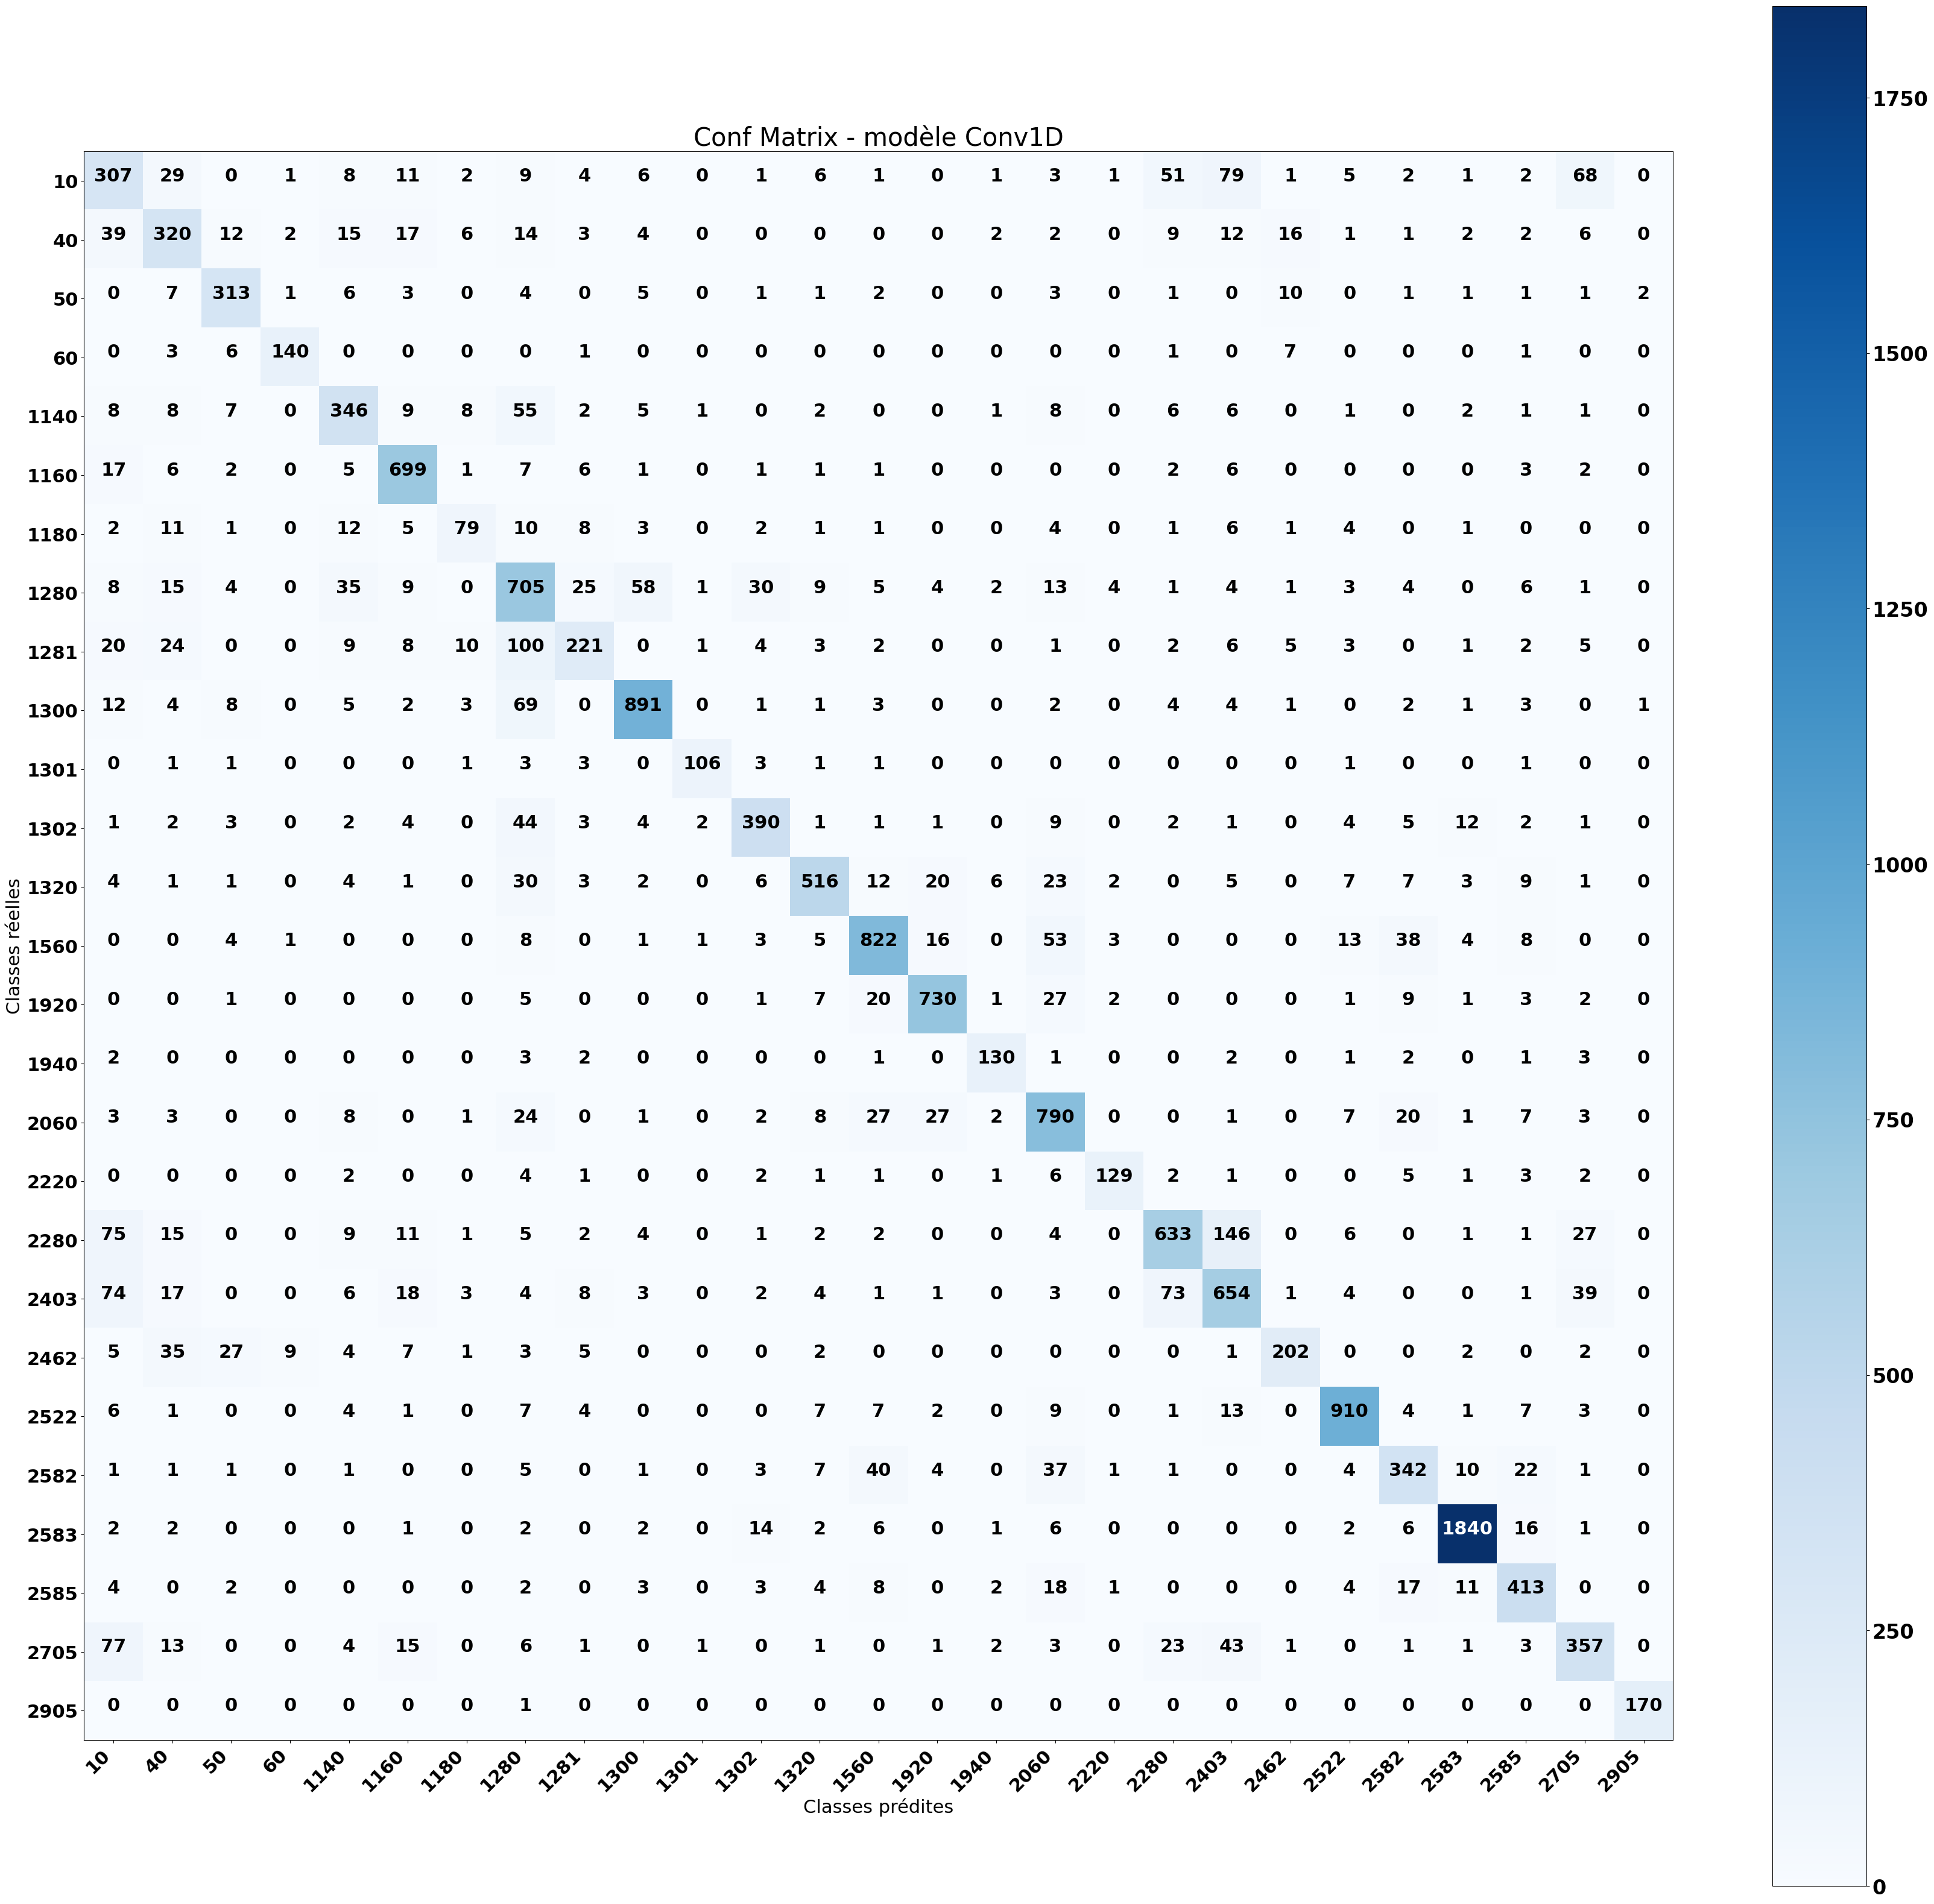

In [46]:
get_conf_matrix(y_true=y_test, y_pred=y_pred, classes= unique_prod_codes, title="Conf Matrix - modèle Conv1D")

#### <a name="conv1.1">🚀Model1.1 (Conv1D)</a>

In [17]:
num_classes = len(unique_prod_codes)

model_conv1D_1 = Sequential()

model_conv1D_1.add(Input(shape=(MAX_SEQUENCE_LENGTH, )) )
model_conv1D_1.add(Embedding(input_dim= vocab_size, output_dim=EMBEDDING_DIM))
model_conv1D_1.add(Conv1D(filters=32, kernel_size=1, padding='valid', activation='relu')) 
model_conv1D_1.add(SpatialDropout1D(0.1))

model_conv1D_1.add(Conv1D(filters=64, kernel_size=1,padding='valid', activation='relu'))
model_conv1D_1.add(SpatialDropout1D(0.1))

model_conv1D_1.add(Conv1D(filters=128, kernel_size=1,padding='valid', activation='relu'))
model_conv1D_1.add(GlobalMaxPool1D()) 

model_conv1D_1.add(Flatten())

model_conv1D_1.add(Dense(units = 20, activation ='relu'))
model_conv1D_1.add(Dense(units = num_classes, activation ='softmax'))

model_conv1D_1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_conv1D_1.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 500, 250)       │    38,178,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 500, 32)        │         8,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_5             │ (None, 500, 32)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 500, 64)        │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_6             │ (None, 500, 64)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 500, 128)       │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │         2,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 27)             │           567 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,200,111 (145.72 MB)

 Trainable params: 38,200,111 (145.72 MB)

 Non-trainable params: 0 (0.00 B)

Training in progress...
=>EPOCHS: 5 =>bach_size: 100
Epoch 1/5
659/659 ━━━━━━━━━━━━━━━━━━━━ 188s 282ms/step - accuracy: 0.3132 - loss: 2.4113 - val_accuracy: 0.6561 - val_loss: 1.2062 - learning_rate: 0.0010
Epoch 2/5
659/659 ━━━━━━━━━━━━━━━━━━━━ 186s 282ms/step - accuracy: 0.6892 - loss: 1.0908 - val_accuracy: 0.7173 - val_loss: 0.9830 - learning_rate: 0.0010
Epoch 3/5
659/659 ━━━━━━━━━━━━━━━━━━━━ 185s 280ms/step - accuracy: 0.7668 - loss: 0.8011 - val_accuracy: 0.7329 - val_loss: 0.9240 - learning_rate: 0.0010
Epoch 4/5
659/659 ━━━━━━━━━━━━━━━━━━━━ 2742s 4s/step - accuracy: 0.8142 - loss: 0.6359 - val_accuracy: 0.7431 - val_loss: 0.9150 - learning_rate: 0.0010
Epoch 5/5
659/659 ━━━━━━━━━━━━━━━━━━━━ 184s 280ms/step - accuracy: 0.8458 - loss: 0.5241 - val_accuracy: 0.7471 - val_loss: 0.9365 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 4.
=>EPOCHS: 10 =>bach_size: 100
Epoch 1/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 185s 280ms/step - accuracy: 0.8452 - loss: 0.

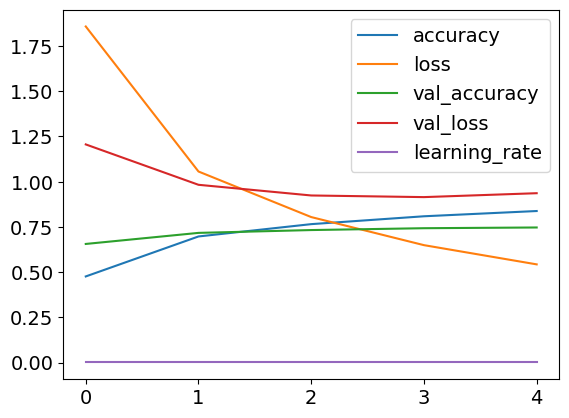

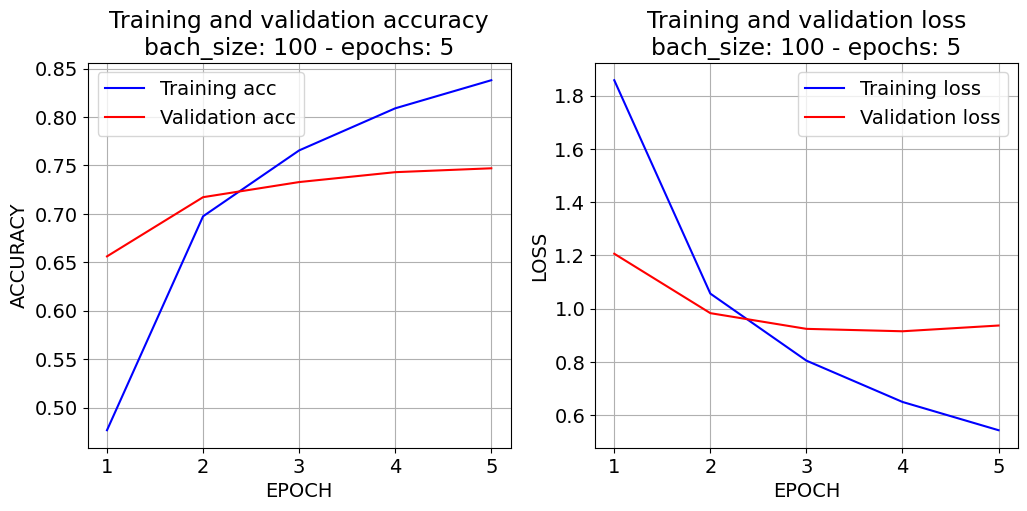

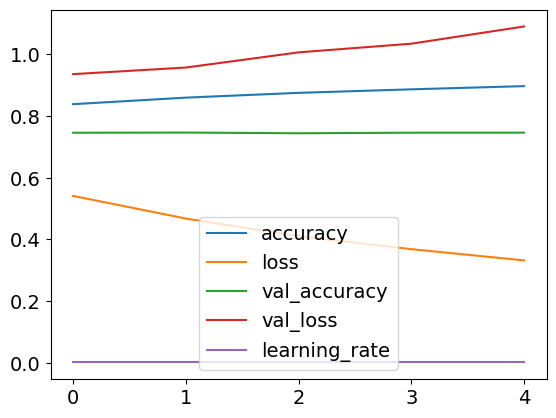

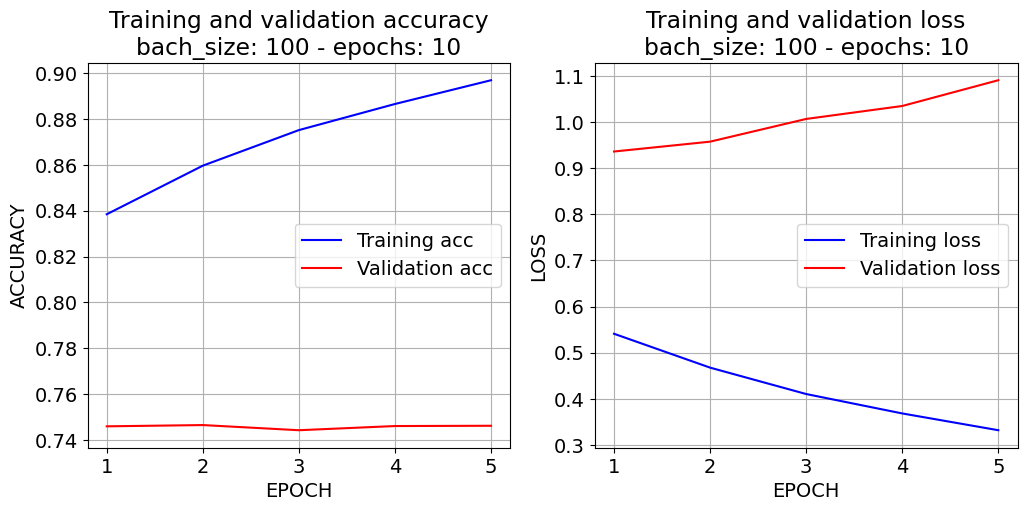

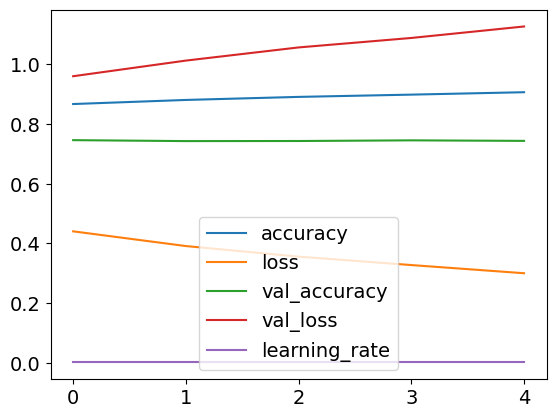

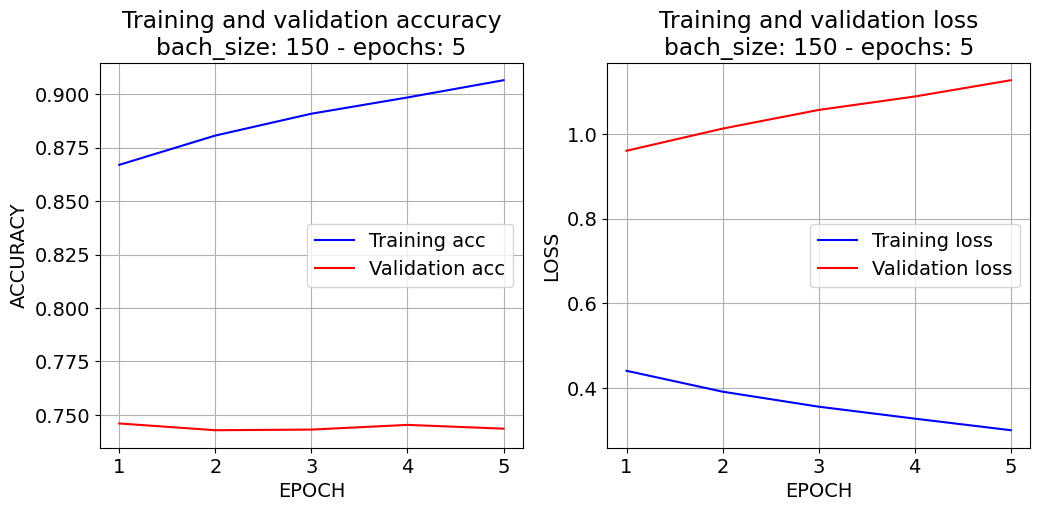

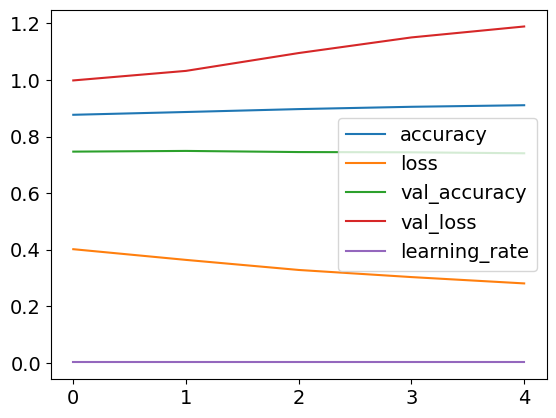

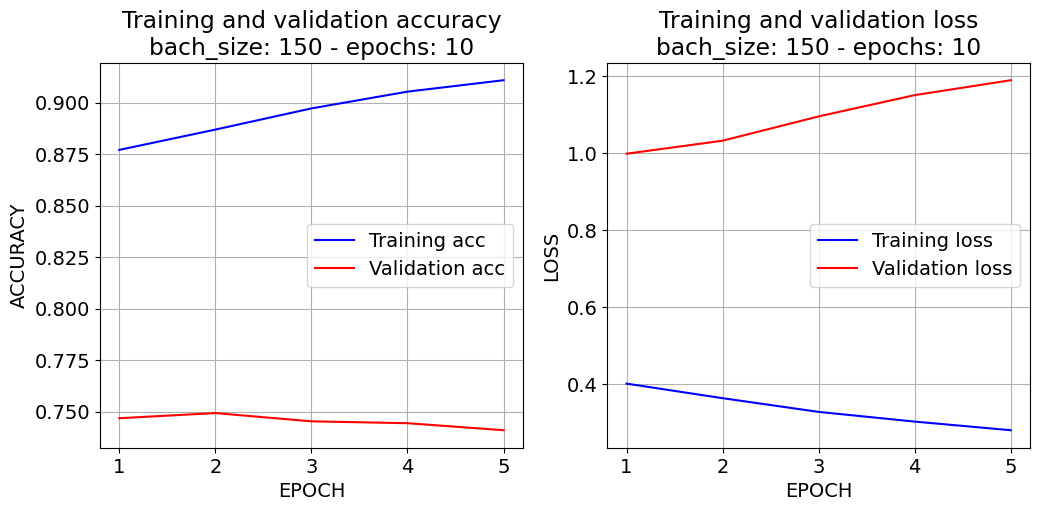

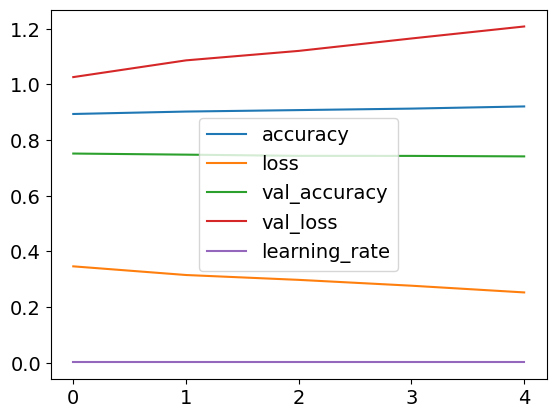

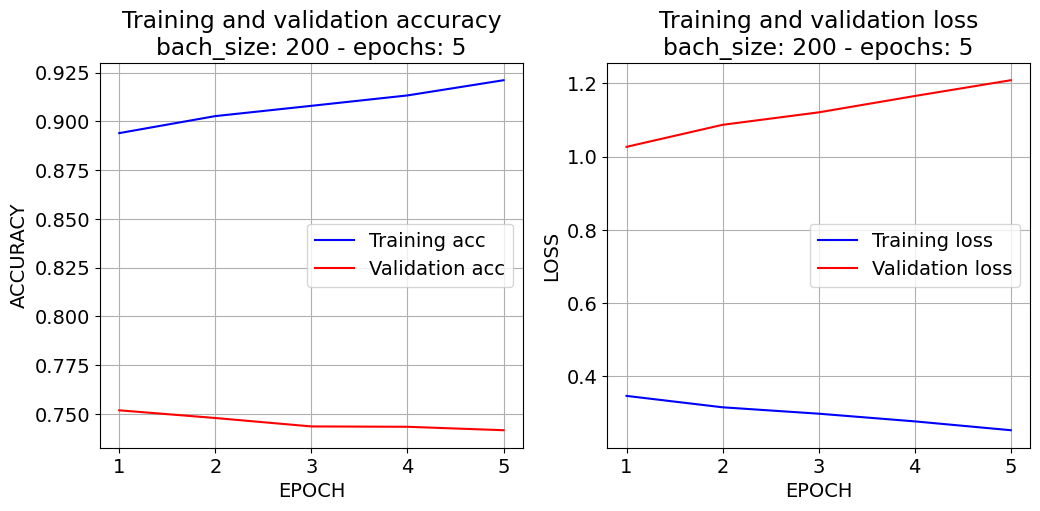

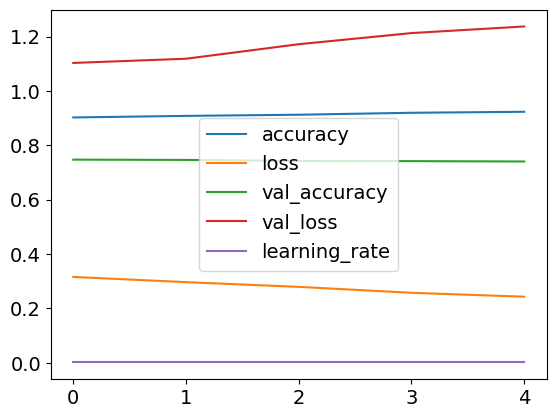

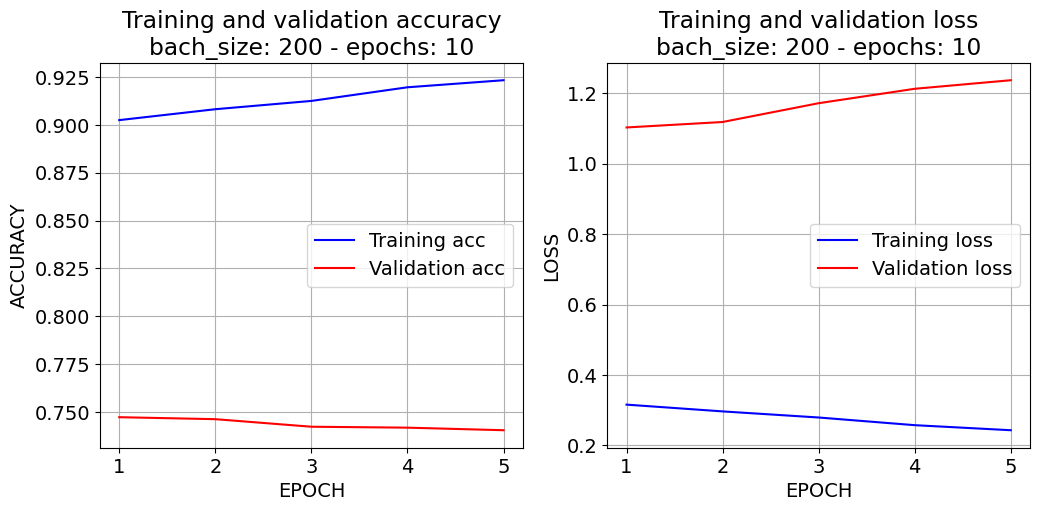

In [18]:
print('Training in progress...')
y_train_enc = to_categorical(y_train, num_classes=num_classes)
y_test_enc = to_categorical(y_test, num_classes=num_classes)

history_text = []
for bach_size in [100, 150, 200]:
    for epochs in [5, 10]:
        print("=>EPOCHS: " + str(epochs) + " =>bach_size: " + str(bach_size) )
        h = model_conv1D_1.fit(train_text, y_train_enc, epochs= epochs, batch_size= bach_size, 
                 validation_data=(test_text, y_test_enc),
                callbacks= callbacks)
        history_text.append (h)
        if hasattr(h, 'history_'):
            pd.DataFrame(h.history_).plot()
        elif hasattr(h, 'history'):
            pd.DataFrame(h.history).plot()
        plot_history(h, cols={'acc': 'accuracy', 'val_acc': 'val_accuracy', 'loss': 'loss', 'val_loss': 'val_loss'},
                    title= '\nbach_size: '+ str(bach_size) + ' - '+ 'epochs: ' + str(epochs))


#### <a name="lstm2">🚀**Modèle2 LSTM**</a> 

In [ ]:
print('Training progress:')
history_text = []
print("----LSTM model----\n====================")
for hidden_nodes in [10, 20, 50, 100]:
    for dense_units in [5, 10, 20]:
        print(f"==>hidden_nodes: {hidden_nodes} dense_units==>{dense_units}")
        def create_lstm_model_text():
            sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
            embedding_layer = Embedding(input_dim= vocab_size, 
                                        output_dim= EMBEDDING_DIM, 
                                        input_length= MAX_SEQUENCE_LENGTH)

            embedded_sequences = embedding_layer(sequence_input)
            x = LSTM(hidden_nodes, return_sequences=True, name='lstm_layer', activation='tanh')(embedded_sequences)  # hidden_nodes = 10
            x = GlobalMaxPool1D()(x)
            x = Dropout(0.2)(x)
            x = Dense(units= dense_units, activation="relu")(x)
            x = Dropout(0.2)(x)
            output = Dense(units= n_classes, activation="softmax")(x)

            return Model(sequence_input, output)

        model_LSTM= create_lstm_model_text()
        model_LSTM.summary()
        model_LSTM.compile(optimizer= 'adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']
             )

        for bach_size in [50, 100, 200]:
            for epochs in [5, 10]:
                print("=>EPOCHS: " + str(epochs) + " =>bach_size: " + str(bach_size) )
                h = model_LSTM.fit(x_train, y_train, epochs=epochs, batch_size=bach_size, 
                         validation_data=(x_test, y_test),
                        callbacks= callbacks)
                if hasattr(h, 'history_'):
                    pd.DataFrame(h.history_).plot()
                    h.history_['hidden_nodes'] = hidden_nodes
                    h.history_['dense_units'] = dense_units
                    h.history_['bach_size'] = bach_size
                    h.history_['epochs'] = epochs
                elif hasattr(h, 'history'):
                    pd.DataFrame(h.history).plot()
                    h.history['hidden_nodes'] = hidden_nodes
                    h.history['dense_units'] = dense_units
                    h.history['bach_size'] = bach_size
                    h.history['epochs'] = epochs

                history_text.append (h)

                plot_history(h, cols={'acc': 'accuracy', 'val_acc': 'val_accuracy', 'loss': 'loss', 'val_loss': 'val_loss'},
                            title= 'bach_size: '+ str(bach_size) + ' - '+ 'epochs: ' + str(epochs))

>Save results to csv file

In [ ]:
#1 Save results
df = pd.DataFrame()
for h in history_text:
    #print(h.history)
    df = pd.concat([pd.DataFrame.from_dict(h.history), df], axis=0)
    
display(df)


hist_csv_file = f"{data_root_folder}\models\historie_LSTM.csv"
with open(hist_csv_file, mode='w') as f:
    df.to_csv(f)

> **Classification report**

In [ ]:
classif_report = get_classif_report(model=model_LSTM, x_test, y_test)
display(classif_report)

>f1_score graph by class

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

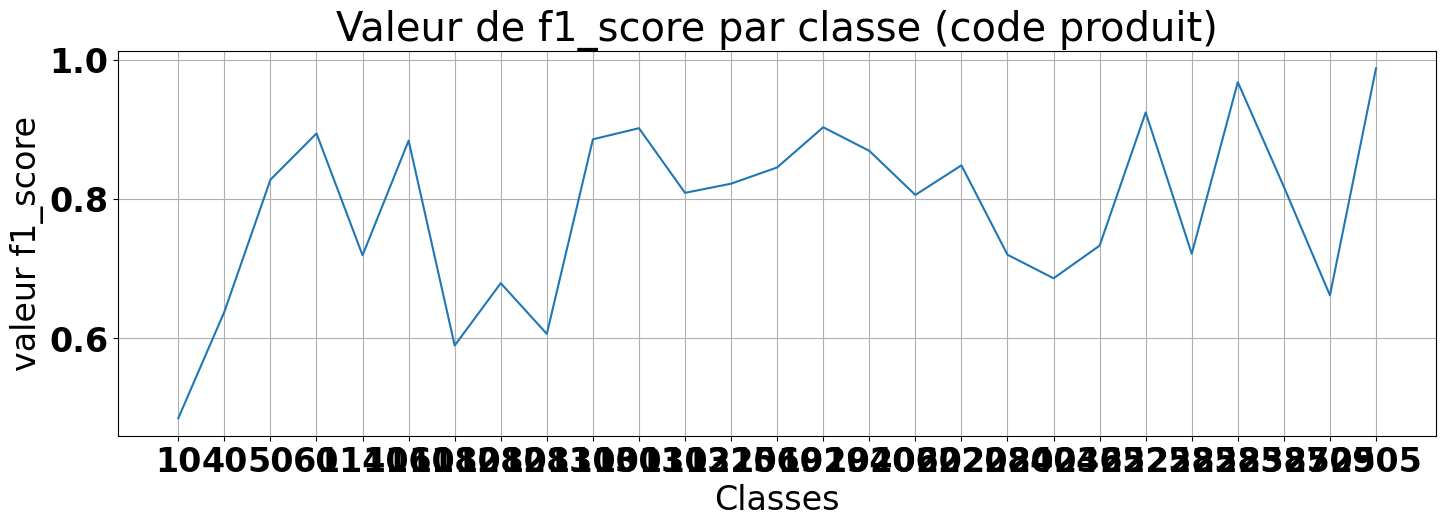

In [48]:
fig, ax = plt.subplots(1,1,figsize=(17, 5))

g = sns.lineplot(x=range(0, 27), y=classif_report.iloc[:27, 3], ax=ax)
g.set_title("Valeur de f1_score par classe (code produit)")
g.grid(True)
g.set_xticks(range(0, 27, 1))
g.set_xlabel("Classes")
g.set_ylabel("valeur f1_score")
g.set_xticklabels(unique_prod_codes)
plt.show()

>Confusion Matrix

0    1    2    3    4    5   6    7    8    9   ...   17   18   19   20  \
0   307   29    0    1    8   11   2    9    4    6  ...    1   51   79    1   
1    39  320   12    2   15   17   6   14    3    4  ...    0    9   12   16   
2     0    7  313    1    6    3   0    4    0    5  ...    0    1    0   10   
3     0    3    6  140    0    0   0    0    1    0  ...    0    1    0    7   
4     8    8    7    0  346    9   8   55    2    5  ...    0    6    6    0   
5    17    6    2    0    5  699   1    7    6    1  ...    0    2    6    0   
6     2   11    1    0   12    5  79   10    8    3  ...    0    1    6    1   
7     8   15    4    0   35    9   0  705   25   58  ...    4    1    4    1   
8    20   24    0    0    9    8  10  100  221    0  ...    0    2    6    5   
9    12    4    8    0    5    2   3   69    0  891  ...    0    4    4    1   
10    0    1    1    0    0    0   1    3    3    0  ...    0    0    0    0   
11    1    2    3    0    2    4   0   44    3    4  ...    0    2    1    0   
12    4    1    1    0    4    1   0   30    3    2  ...    2    0    5    0   
13    0    0    4    1    0    0   0    8    0    1  ...    3    0    0    0   
14    0    0    1    0    0    0   0    5    0    0  ...    2    0    0    0   
15    2    0    0    0    0    0   0    3    2    0  ...    0    0    2    0   
16    3    3    0    0    8    0   1   24    0    1  ...    0    0    1    0   
17    0    0    0    0    2    0   0    4    1    0  ...  129    2    1    0   
18   75   15    0    0    9   11   1    5    2    4  ...    0  633  146    0   
19   74   17    0    0    6   18   3    4    8    3  ...    0   73  654    1   
20    5   35   27    9    4    7   1    3    5    0  ...    0    0    1  202   
21    6    1    0    0    4    1   0    7    4    0  ...    0    1   13    0   
22    1    1    1    0    1    0   0    5    0    1  ...    1    1    0    0   
23    2    2    0    0    0    1   0    2    0    2  ...    0    0    0    0   
24    4    0    2    0    0    0   0    2    0    3  ...    1    0    0    0   
25   77   13    0    0    4   15   0    6    1    0  ...    0   23   43    1   
26    0    0    0    0    0    0   0    1    0    0  ...    0    0    0    0   

     21   22    23   24   25   26  
0     5    2     1    2   68    0  
1     1    1     2    2    6    0  
2     0    1     1    1    1    2  
3     0    0     0    1    0    0  
4     1    0     2    1    1    0  
5     0    0     0    3    2    0  
6     4    0     1    0    0    0  
7     3    4     0    6    1    0  
8     3    0     1    2    5    0  
9     0    2     1    3    0    1  
10    1    0     0    1    0    0  
11    4    5    12    2    1    0  
12    7    7     3    9    1    0  
13   13   38     4    8    0    0  
14    1    9     1    3    2    0  
15    1    2     0    1    3    0  
16    7   20     1    7    3    0  
17    0    5     1    3    2    0  
18    6    0     1    1   27    0  
19    4    0     0    1   39    0  
20    0    0     2    0    2    0  
21  910    4     1    7    3    0  
22    4  342    10   22    1    0  
23    2    6  1840   16    1    0  
24    4   17    11  413    0    0  
25    0    1     1    3  357    0  
26    0    0     0    0    0  170  

[27 rows x 27 columns]

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

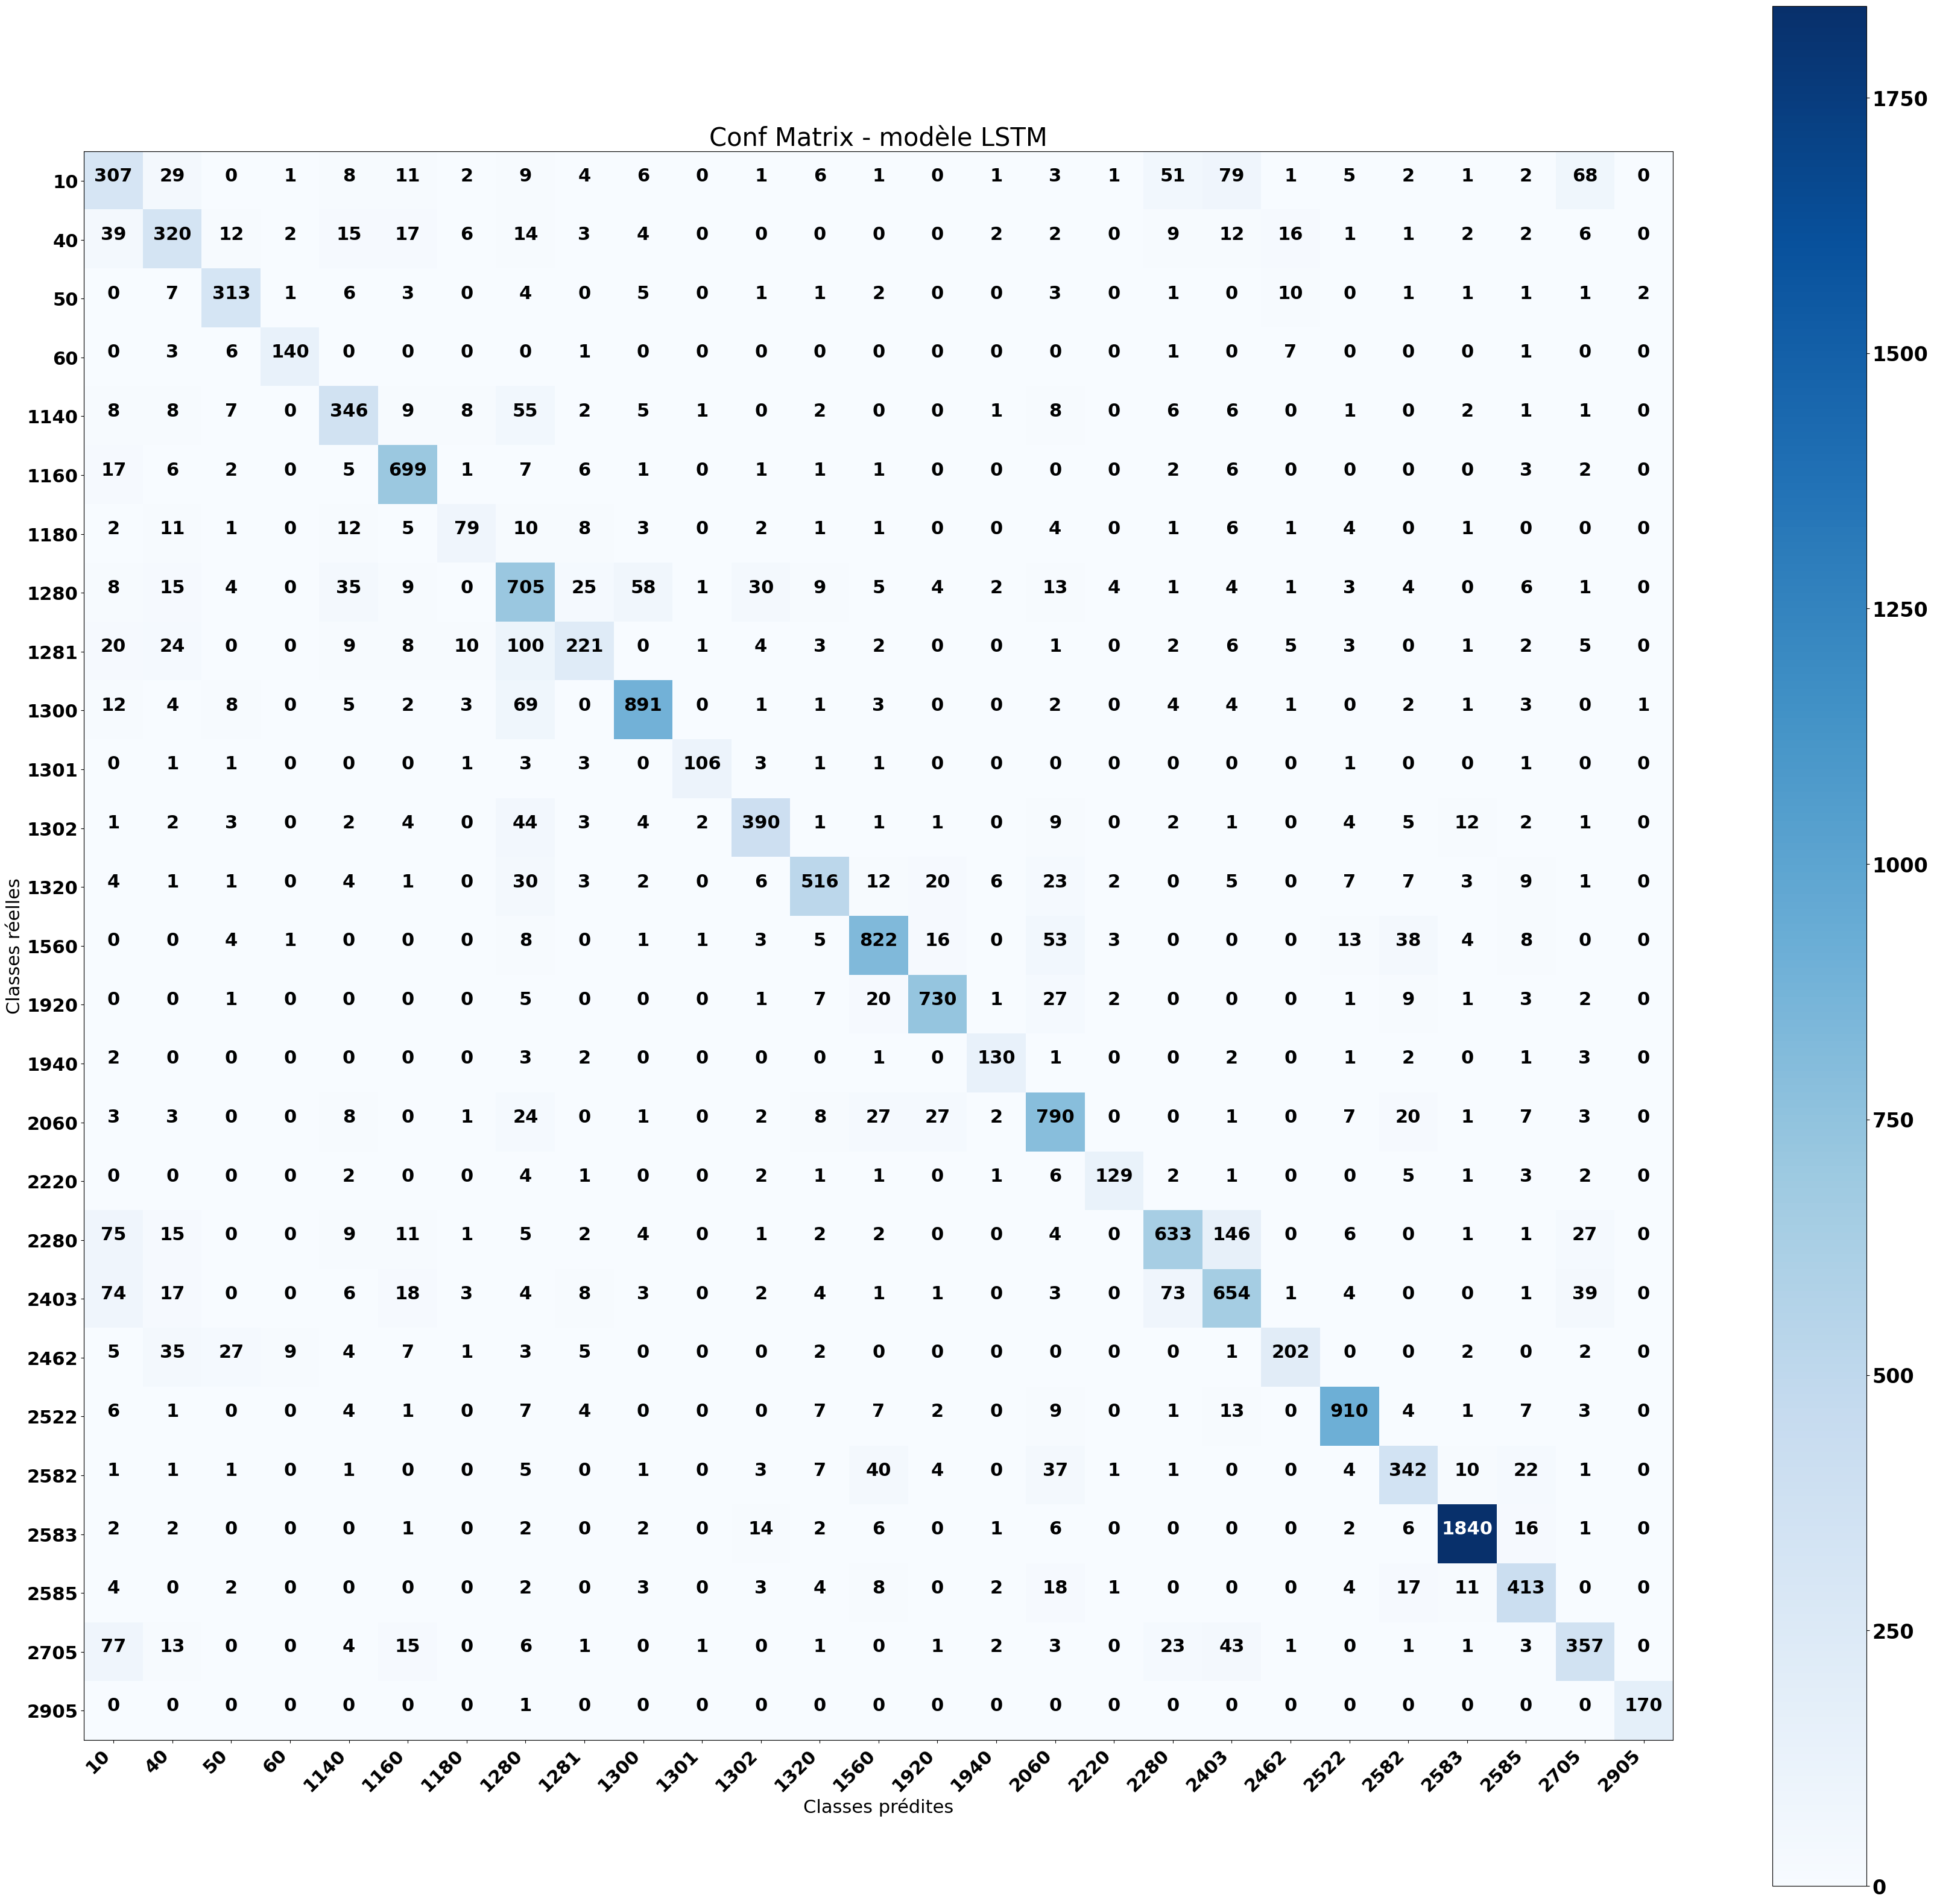

In [56]:
get_conf_matrix(y_true=y_test, y_pred=y_pred, classes= unique_prod_codes, title="Conf Matrix - modèle LSTM")


> Précision globale

In [95]:
y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)
print(list(y_test_class))
print(list(y_pred_class))
mask = y_test_class - y_pred_class
print(list(mask))
n_OK, count_OK = np.unique(np.where(mask==0), return_counts= True)
n_KO, count_KO = np.unique(np.where(mask!=0), return_counts= True)      

print("--->N de bonnes prédictions =", len(count_OK))
print("--->N de mauvaises prédictions =", len(count_KO))
print("--->Précision (%) :", 100-round(100*len(count_KO)/len(count_OK), 0), "%")

AxisError: axis 1 is out of bounds for array of dimension 1

> Prédictions

In [ ]:

# save predictions
y_pred_df = get_predictions(model_conv1D, x_test=x_test, save_to_csv=True, csv_file_name="conv1D_model_text_1.csv")
display(y_pred_df)
#pd.DataFrame(y_pred_df).hist()
print(pd.DataFrame(y_pred_df).shape)



#fig, ax = plt.subplots(1,1,figsize=(15, 7))
#sns.lineplot(data=y_pred_df, x=)

#### C1.2 Equilibrage via SMOTE

In [10]:
tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_text['desi_desc'].values.ravel())
X_text_vec = vectorizer.transform(X_text['desi_desc'].values.ravel())
# Get our train data word index
#X_test_word_index = tokenizer.word_index

In [15]:


#X_text_vec = pd.DataFrame(X_text_vec)
X_smote, y_smote = SMOTE().fit_resample(X_text_vec, target)


In [18]:
display(X_smote)

<262359x150706 sparse matrix of type '<class 'numpy.int64'>'
	with 7099863 stored elements in Compressed Sparse Row format>

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=.2, random_state=42)

In [17]:
X_train = X_train.astype(int)
X_test = X_test.astype(int)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

> Create now the same model as in case of umbalenced dataset

In [21]:
# Adding 1 because of reserved Keras 0 index
vocab_size = X_train.shape[0] + 1  
print("vocab_size=", vocab_size)


def create_model_text_balanced():
    sequence_input = Input(shape=(X_train.transpose().shape[0], ))
    embedding_layer = Embedding(input_dim= vocab_size, 
                                output_dim= EMBEDDING_DIM, 
                                input_length= X_train.transpose().shape[0])
                                
    embedded_sequences = embedding_layer(sequence_input)
    x = LSTM(60, return_sequences=True, name='lstm_layer', activation='tanh')(embedded_sequences)  # hidden_nodes = 60
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.2)(x)
    output = Dense(units= n_classes, activation="softmax")(x)
    
    return Model(sequence_input, output)
    

>Entrainer le modèle **avec le balancing**

In [22]:
# Create the model
model_text_balanced = create_model_text_balanced()

# Compile the model
model_text_balanced.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_text_balanced.summary()

d:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.

  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150706)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 150706, 500)    │   104,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 150706, 60)     │       134,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 60)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │         1,377 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,083,067 (400.86 MB)

 Trainable params: 105,083,067 (400.86 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:

print('Training progress:')
y_train = to_categorical(y_train, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)
print(y_train.shape)
print(y_test.shape)

history_model_text_balanced = model_text_balanced.fit(X_train, y_train.transpose(),
                    epochs = 10, batch_size=100,
                    validation_data=(X_test, y_test.transpose()),
                    callbacks = [lr_plateau, early_stopping, time_callback])

Training progress:


MemoryError: Unable to allocate 30.8 GiB for an array with shape (153007623, 27) and data type float64

>Réaliser des prédictions

In [ ]:
desc = ["Je souhaite achter une poupée ou un jeu vidéo pour l'anniversaire de ma fille."]
seq = tokenizer.texts_to_sequences(desc)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = range(0, 27)
print(pred, labels[np.argmax(pred)])

### C1.2 **GridSearchCV**

Réf. https://medium.com/@AIandInsights/hyperparameter-tuning-with-keras-and-gridsearchcv-a-comprehensive-guide-46214cc0d999#:~:text=Use%20cross-validation%20to%20evaluate%20the%20performance%20of%20each,optimization%20to%20ensure%20convergence%20and%20avoid%20premature%20termination.

In [62]:
# Define Keras model function
def create_grid_model():
    model = Sequential()
    model.add( Input(shape=(MAX_SEQUENCE_LENGTH,)) )
    model.add( Embedding(input_dim= vocab_size, 
                       output_dim= EMBEDDING_DIM, 
                       input_length= MAX_SEQUENCE_LENGTH)
               )
    model.add( LSTM(64, return_sequences=True, name='lstm_layer', activation= 'tanh')) # hidden_nodes = 60
    model.add( GlobalMaxPool1D() )
    model.add( Dropout(.1) )
    model.add( Dense(50, activation="relu") )
    model.add( Dropout(.1) )
    model.add( Dense(units= n_classes, activation="softmax") )
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


# Create KerasClassifier
model = KerasClassifier(model=create_grid_model, verbose=0 )
print(model.get_params().keys())

# Define hyperparameter grid
#
#param_grid = {
#    'optimizer': ['adam', 'sgd', 'rmsprop'],
#    'activation': ['relu', 'sigmoid', 'tanh'],
#    'last_activation': ['softmax', 'sugmoid'],
#    'dropout_ratio': [.2],
#    'epochs': [5, 10, 20],
#    'batch_size': [50, 100, 150, 200, 300, 500]
#}

param_grid = {
    'epochs': [5, 10, 15],
    'batch_size': [20, 50, 100]
}

 # define the grid search parameters
batch_size = [20, 50, 100]
epochs = [5, 10, 15]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Perform GridSearchCV
gs_grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
gs_grid_result = gs_grid.fit(train_x, y_train,
                    validation_data=(val_x, y_test),
                    callbacks = [lr_plateau, early_stopping, time_callback])

# get best params
best_params=gs_grid.best_params_ 
accuracy=gs_grid.best_score_ 


dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'class_weight'])


d:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.

  warnings.warn(

d:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.

  warnings.warn(

d:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.

  warnings.warn(

d:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.

  warnings.warn(

d:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.

  warnings.warn(

d:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.

  warnings.warn(

d:\Python312\Lib\site-packages\keras\src\layers\core\embed

: 

### 🚀C1.3 **[OPTIONNEL]** SMOTE Resampling pour équilibrage - ***abandonné***

>Ce resampling ne peut être opéré sur le dataset (textuel), il faut d'abord le vevtoriser, ce qui peut être couteux !

In [ ]:

#X_text_vec = pd.DataFrame(X_text_vec)
X_smote, y_smote = SMOTE().fit_resample(X_text, target)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=.2, random_state=42)


ValueError: could not convert string to float: 'olivia personalisiertes notizbuch seiten punktraster din rosendesign'

In [ ]:
# Adding 1 because of reserved Keras 0 index
vocab_size = X_train_smote.shape[0] + 1  
print("vocab_size=", vocab_size)


def create_model_text_smote_balanced():
    sequence_input = Input(shape=(X_train_smote.shape[0], ))
    embedding_layer = Embedding(input_dim= vocab_size, 
                                output_dim= EMBEDDING_DIM, 
                                input_length= X_train_smote.shape[0])
                                
    embedded_sequences = embedding_layer(sequence_input)
    x = LSTM(60, return_sequences=True, name='lstm_layer', activation='tanh')(embedded_sequences)  # hidden_nodes = 60
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.2)(x)
    output = Dense(units= n_classes, activation="softmax")(x)
    
    return Model(sequence_input, output)

In [ ]:
# Create the model
model_text_balanced = create_model_text_smote_balanced()

# Compile the model
model_text_balanced.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_text_balanced.summary()

In [ ]:
print('Training progress:')
y_train_1 = to_categorical(y_train, num_classes=n_classes)
y_test_1 = to_categorical(y_test, num_classes=n_classes)
print(y_train_1.shape)
print(y_test_1.shape)

history_model_text_balanced = model_text_balanced.fit(X_train, y_train_1.transpose(),
                    epochs = 10, batch_size=100,
                    validation_data=(X_test, y_test_1.transpose()),
                    callbacks = [lr_plateau, early_stopping, time_callback])